In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.gaussian_process.kernels import Product
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

In [2]:
booking_df = pd.read_csv("Booking_cleaned.csv")
expedia_df = pd.read_csv("Expedia_cleaned.csv")

In [3]:
booking_df['Name'] = booking_df['Name'].str.replace('/Chelsea', '')
booking_df['Name'] = booking_df['Name'].str.replace('/', ' ')
booking_df['Name'] = booking_df['Name'].str.replace('-', ' ')
booking_df['Name'] = booking_df['Name'].str.replace(',', '')
booking_df['Name'] = booking_df['Name'].str.replace(' Hotel', '')
booking_df['Name'] = booking_df['Name'].str.replace(' NYC ', '')
booking_df['Name'] = booking_df['Name'].str.replace(' NYC', '')
booking_df['Name'] = booking_df['Name'].str.replace('Retreats', '')
booking_df['Name'] = booking_df['Name'].str.replace(' New York', '')


In [ ]:
booking_df['Name'].unique()

In [5]:
expedia_df['Name'] = expedia_df['Name'].str.replace('/', ' ', regex=True)
expedia_df['Name'] = expedia_df['Name'].str.replace('-', ' ', regex=True)
expedia_df['Name'] = expedia_df['Name'].str.replace(' Hotel', '', regex=True)
expedia_df['Name'] = expedia_df['Name'].str.replace(' NYC ', '', regex=True)
expedia_df['Name'] = expedia_df['Name'].str.replace(' NYC', '', regex=True)
expedia_df['Name'] = expedia_df['Name'].str.replace(' New York', '', regex=True)


In [ ]:
expedia_df['Name'].unique()

In [9]:
booking_df.shape

(41004, 47)

In [10]:
booking_m = booking_df[['Name','WebIndex','NumOfWeekendDays','Nights','Review','Rating','PricePerNight','SnapShotMonth', 'SnapShotDay'
                        , 'CheckinMonth', 'CheckinDay','CheckoutMonth', 'CheckoutDay','Price']]

In [11]:
booking_m

,Name,WebIndex,NumOfWeekendDays,Nights,Review,Rating,PricePerNight,SnapShotMonth,SnapShotDay,CheckinMonth,CheckinDay,CheckoutMonth,CheckoutDay,Price
0,Pestana Park Avenue,1,0.0,1.0,850,7.0,199.0,3,1,3,2,3,3,199
1,Margaritaville Resort Times Square,2,0.0,1.0,1355,8.0,149.0,3,1,3,2,3,3,149
2,The Tuscany Powered by LuxUrban,3,0.0,1.0,45,6.0,86.0,3,1,3,2,3,3,86
3,Pod Times Square,4,0.0,1.0,12746,7.0,99.0,3,1,3,2,3,3,99
4,Hyatt Place City Times Square,5,0.0,1.0,14983,6.0,155.0,3,1,3,2,3,3,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40999,Hotel Hugo,98,2.0,5.0,479,6.0,243.0,3,3,4,1,4,6,1215
41000,Riu Plaza Manhattan Times Square,99,2.0,5.0,6415,8.0,362.0,3,3,4,1,4,6,1809
41001,The Time,100,2.0,5.0,1211,6.0,265.0,3,3,4,1,4,6,1326
41002,The Renwick,1,2.0,5.0,1020,7.0,345.0,3,3,4,1,4,6,1724


In [12]:
expedia_m = expedia_df[['Name','WebIndex','NumOfWeekendDays','Nights','Review','Rating','Price','SnapShotMonth', 'SnapShotDay'
                        , 'CheckinMonth', 'CheckinDay','CheckoutMonth', 'CheckoutDay','TotalPrice']]

In [13]:
booking_m.rename(
    columns={'Price':'TotalPrice'},
    inplace=True,
)
expedia_m.rename(
    columns={'Price':'PricePerNight'},
    inplace=True,
)


# Merging (_x = Booing , _y= Expedia

In [14]:
merged_df = pd.merge(booking_m,expedia_m,how='inner', left_on=['Name', 'CheckinDay', 'CheckoutDay'],right_on=['Name', 'CheckinDay', 'CheckoutDay'])

In [15]:
merged_df

,Name,WebIndex_x,NumOfWeekendDays_x,Nights_x,Review_x,Rating_x,PricePerNight_x,SnapShotMonth_x,SnapShotDay_x,CheckinMonth_x,...,NumOfWeekendDays_y,Nights_y,Review_y,Rating_y,PricePerNight_y,SnapShotMonth_y,SnapShotDay_y,CheckinMonth_y,CheckoutMonth_y,TotalPrice_y
0,Pestana Park Avenue,1,0.0,1.0,850,7.0,199.0,3,1,3,...,0,1.0,321,8.0,329,3.0,1.0,3.0,3.0,329.0
1,Pestana Park Avenue,92,0.0,1.0,850,7.0,199.0,3,1,3,...,0,1.0,321,8.0,329,3.0,1.0,3.0,3.0,329.0
2,Pestana Park Avenue,66,0.0,1.0,852,7.0,175.0,2,27,3,...,0,1.0,321,8.0,329,3.0,1.0,3.0,3.0,329.0
3,Pestana Park Avenue,77,0.0,1.0,852,7.0,175.0,2,27,3,...,0,1.0,321,8.0,329,3.0,1.0,3.0,3.0,329.0
4,Margaritaville Resort Times Square,2,0.0,1.0,1355,8.0,149.0,3,1,3,...,0,1.0,1638,9.0,409,3.0,1.0,3.0,3.0,409.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21185,Lotte Palace,77,2.0,5.0,330,7.0,594.0,3,3,4,...,2,5.0,1002,8.0,652,3.0,3.0,4.0,4.0,3260.0
21186,Roxy,80,2.0,5.0,953,7.0,387.0,3,3,4,...,2,5.0,1059,9.0,440,2.0,27.0,3.0,3.0,2200.0
21187,Roxy,80,2.0,5.0,953,7.0,387.0,3,3,4,...,2,5.0,1000,9.0,512,3.0,3.0,4.0,4.0,2560.0
21188,The Renwick,1,2.0,5.0,1020,7.0,345.0,3,3,4,...,2,5.0,1092,8.0,388,2.0,27.0,3.0,3.0,1940.0


In [16]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
WebIndex_x,21190.0,46.999906,28.962768,1.0,22.0,45.0,71.00,100.0
NumOfWeekendDays_x,21190.0,0.852714,0.824701,0.0,0.0,1.0,2.00,2.0
Nights_x,21190.0,2.953280,1.425709,1.0,2.0,3.0,4.00,5.0
Review_x,21190.0,2319.234545,2376.447628,3.0,845.0,1506.0,2783.75,14988.0
Rating_x,21190.0,6.825672,0.832014,5.0,6.0,7.0,7.00,9.0
PricePerNight_x,21190.0,267.638131,78.608290,87.0,212.0,259.0,309.00,773.0
SnapShotMonth_x,21190.0,2.670411,0.470075,2.0,2.0,3.0,3.00,3.0
SnapShotDay_x,21190.0,10.300802,11.737418,1.0,1.0,3.0,27.00,27.0
CheckinMonth_x,21190.0,3.002454,0.138401,2.0,3.0,3.0,3.00,4.0
CheckinDay,21190.0,15.123266,8.037790,1.0,8.0,15.0,22.00,31.0


In [17]:
merged_df.shape

(21190, 25)

In [18]:
## IQR = Q3 - Q1
## Price
price_q1 , price_q3 = np.percentile(merged_df['TotalPrice_x'],[25,75])
priceIQR = (price_q3 - price_q1)
priceTUK = price_q3 + (1.5 * (priceIQR))

#remove outliers from 'Price'
#CODE HERE
merged_df = merged_df[~(merged_df['TotalPrice_x'] > (priceTUK))]

## IQR = Q3 - Q1
## Price
price_q1 , price_q3 = np.percentile(merged_df['TotalPrice_y'],[25,75])
priceIQR = (price_q3 - price_q1)
priceTUK = price_q3 + (1.5 * (priceIQR))

#remove outliers from 'Price'
#CODE HERE
merged_df = merged_df[~(merged_df['TotalPrice_y'] > (priceTUK))]

In [19]:
merged_df.shape

(20944, 25)

# EDA

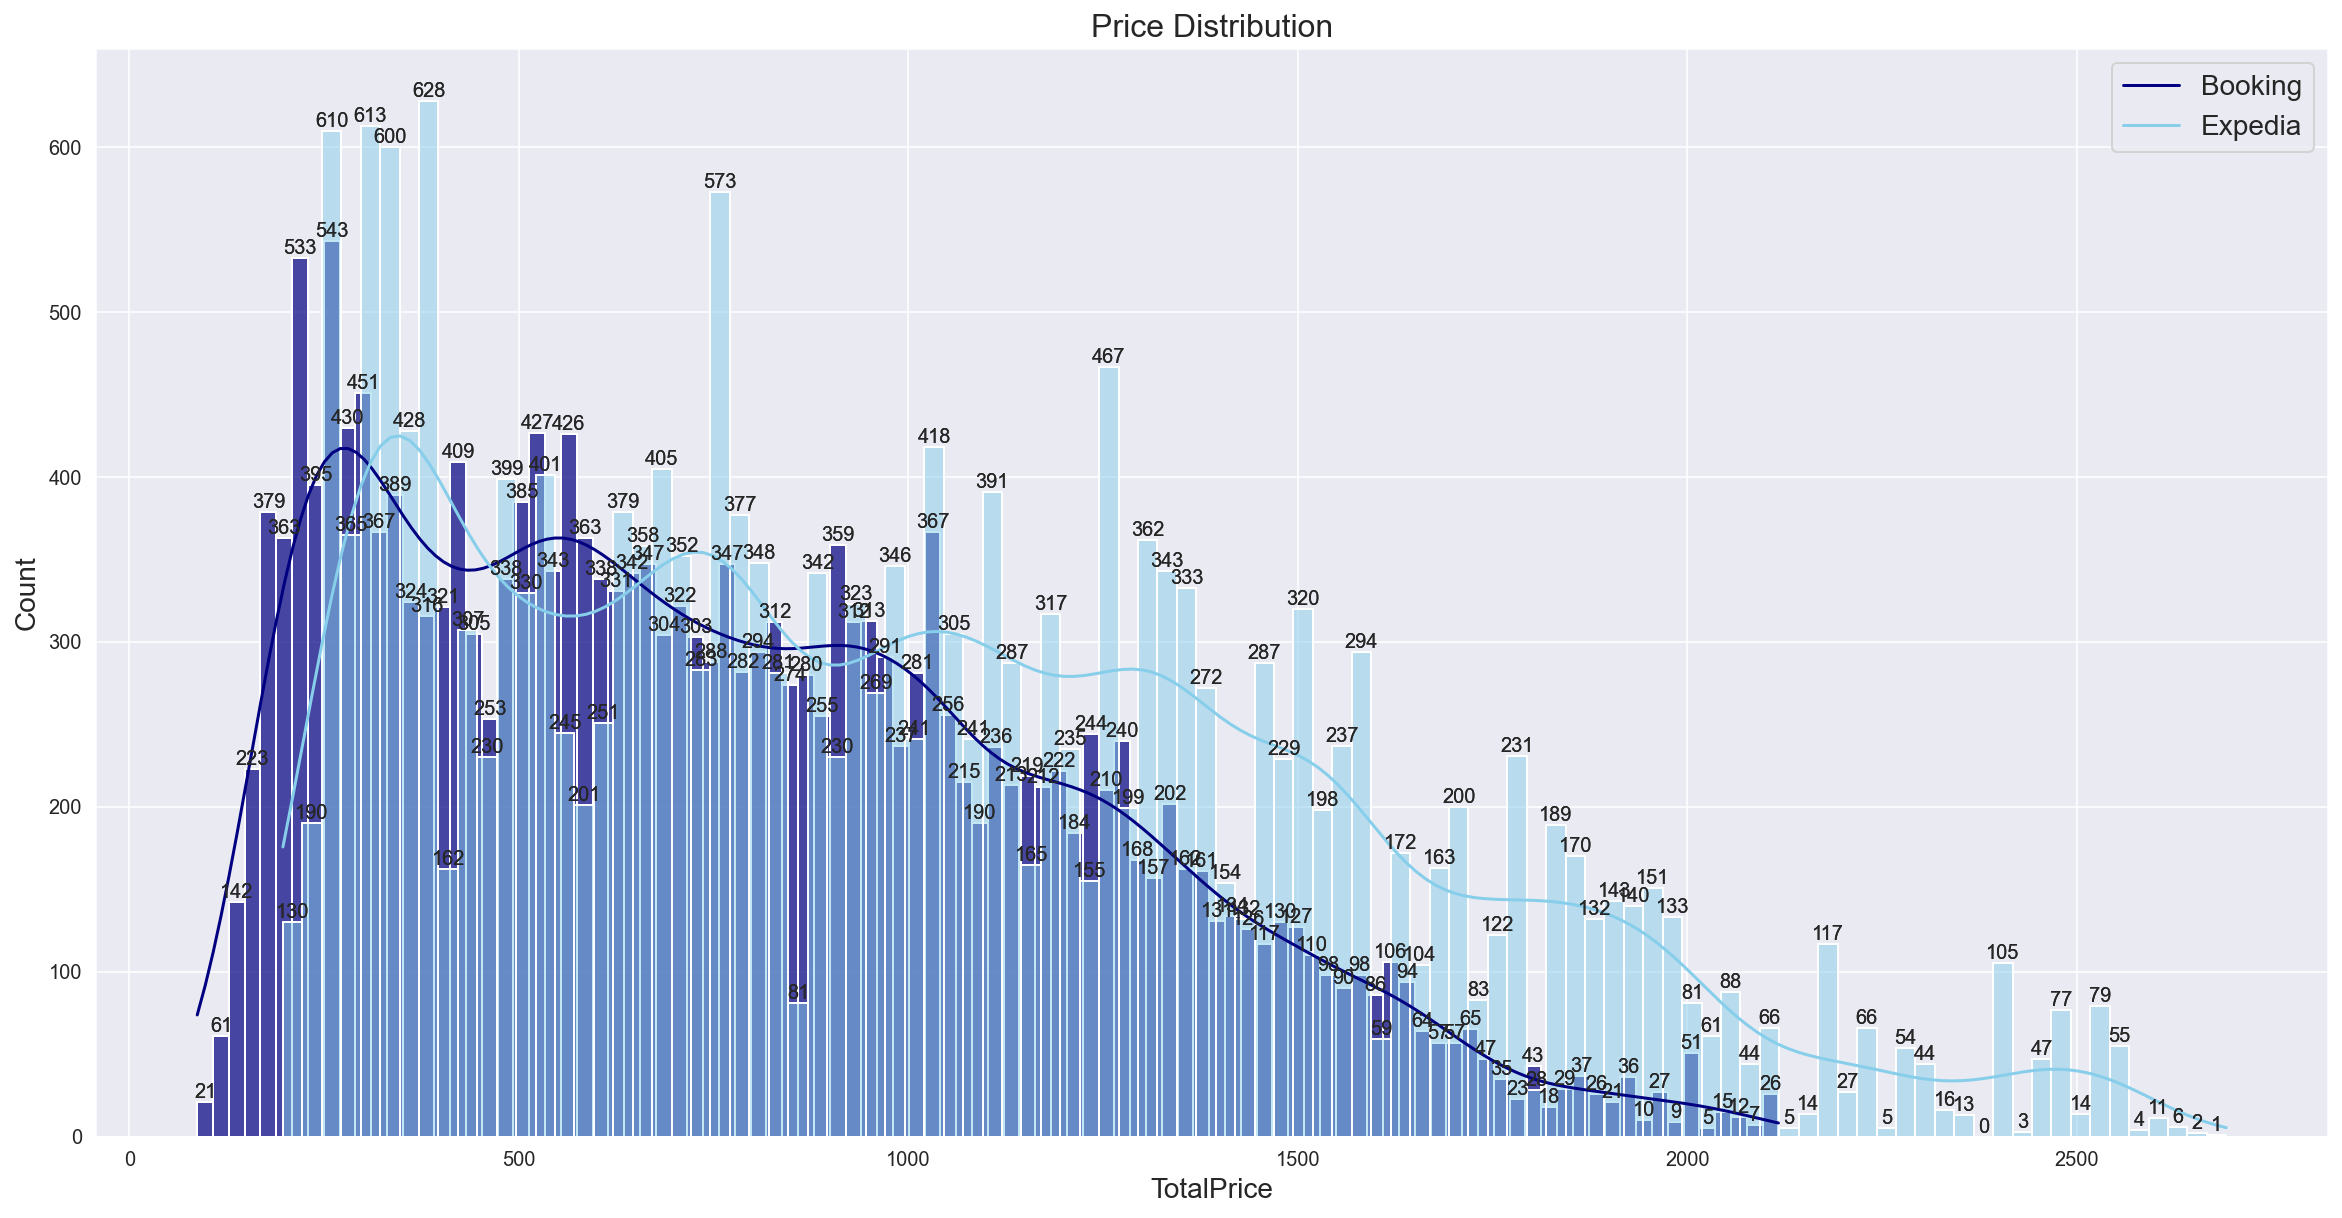

In [20]:
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(20, 10))

ax = sns.histplot(merged_df['TotalPrice_x'], bins=100, kde=True, alpha=0.7, color='navy')
bx = sns.histplot(merged_df['TotalPrice_y'], bins=100, kde=True, alpha=0.5, color='skyblue')

plt.legend(['Booking','Expedia'], fontsize=14)
plt.xlabel('TotalPrice', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Price Distribution', fontsize=16)

for rect in ax.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10)

for rect in bx.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10)

plt.show()

In [21]:
#If PriceDiff > 0 = Expedia is more expensive
#If PriceDiff < 0 = Booking more expensive

merged_df["PriceDiff"] = merged_df["TotalPrice_y"] - merged_df["TotalPrice_x"]

In [22]:
merged_df["PriceDiff"].describe()

count    20944.000000
mean       238.178953
std        292.375273
min      -1011.000000
25%         58.000000
50%        179.000000
75%        387.000000
max       1845.000000
Name: PriceDiff, dtype: float64

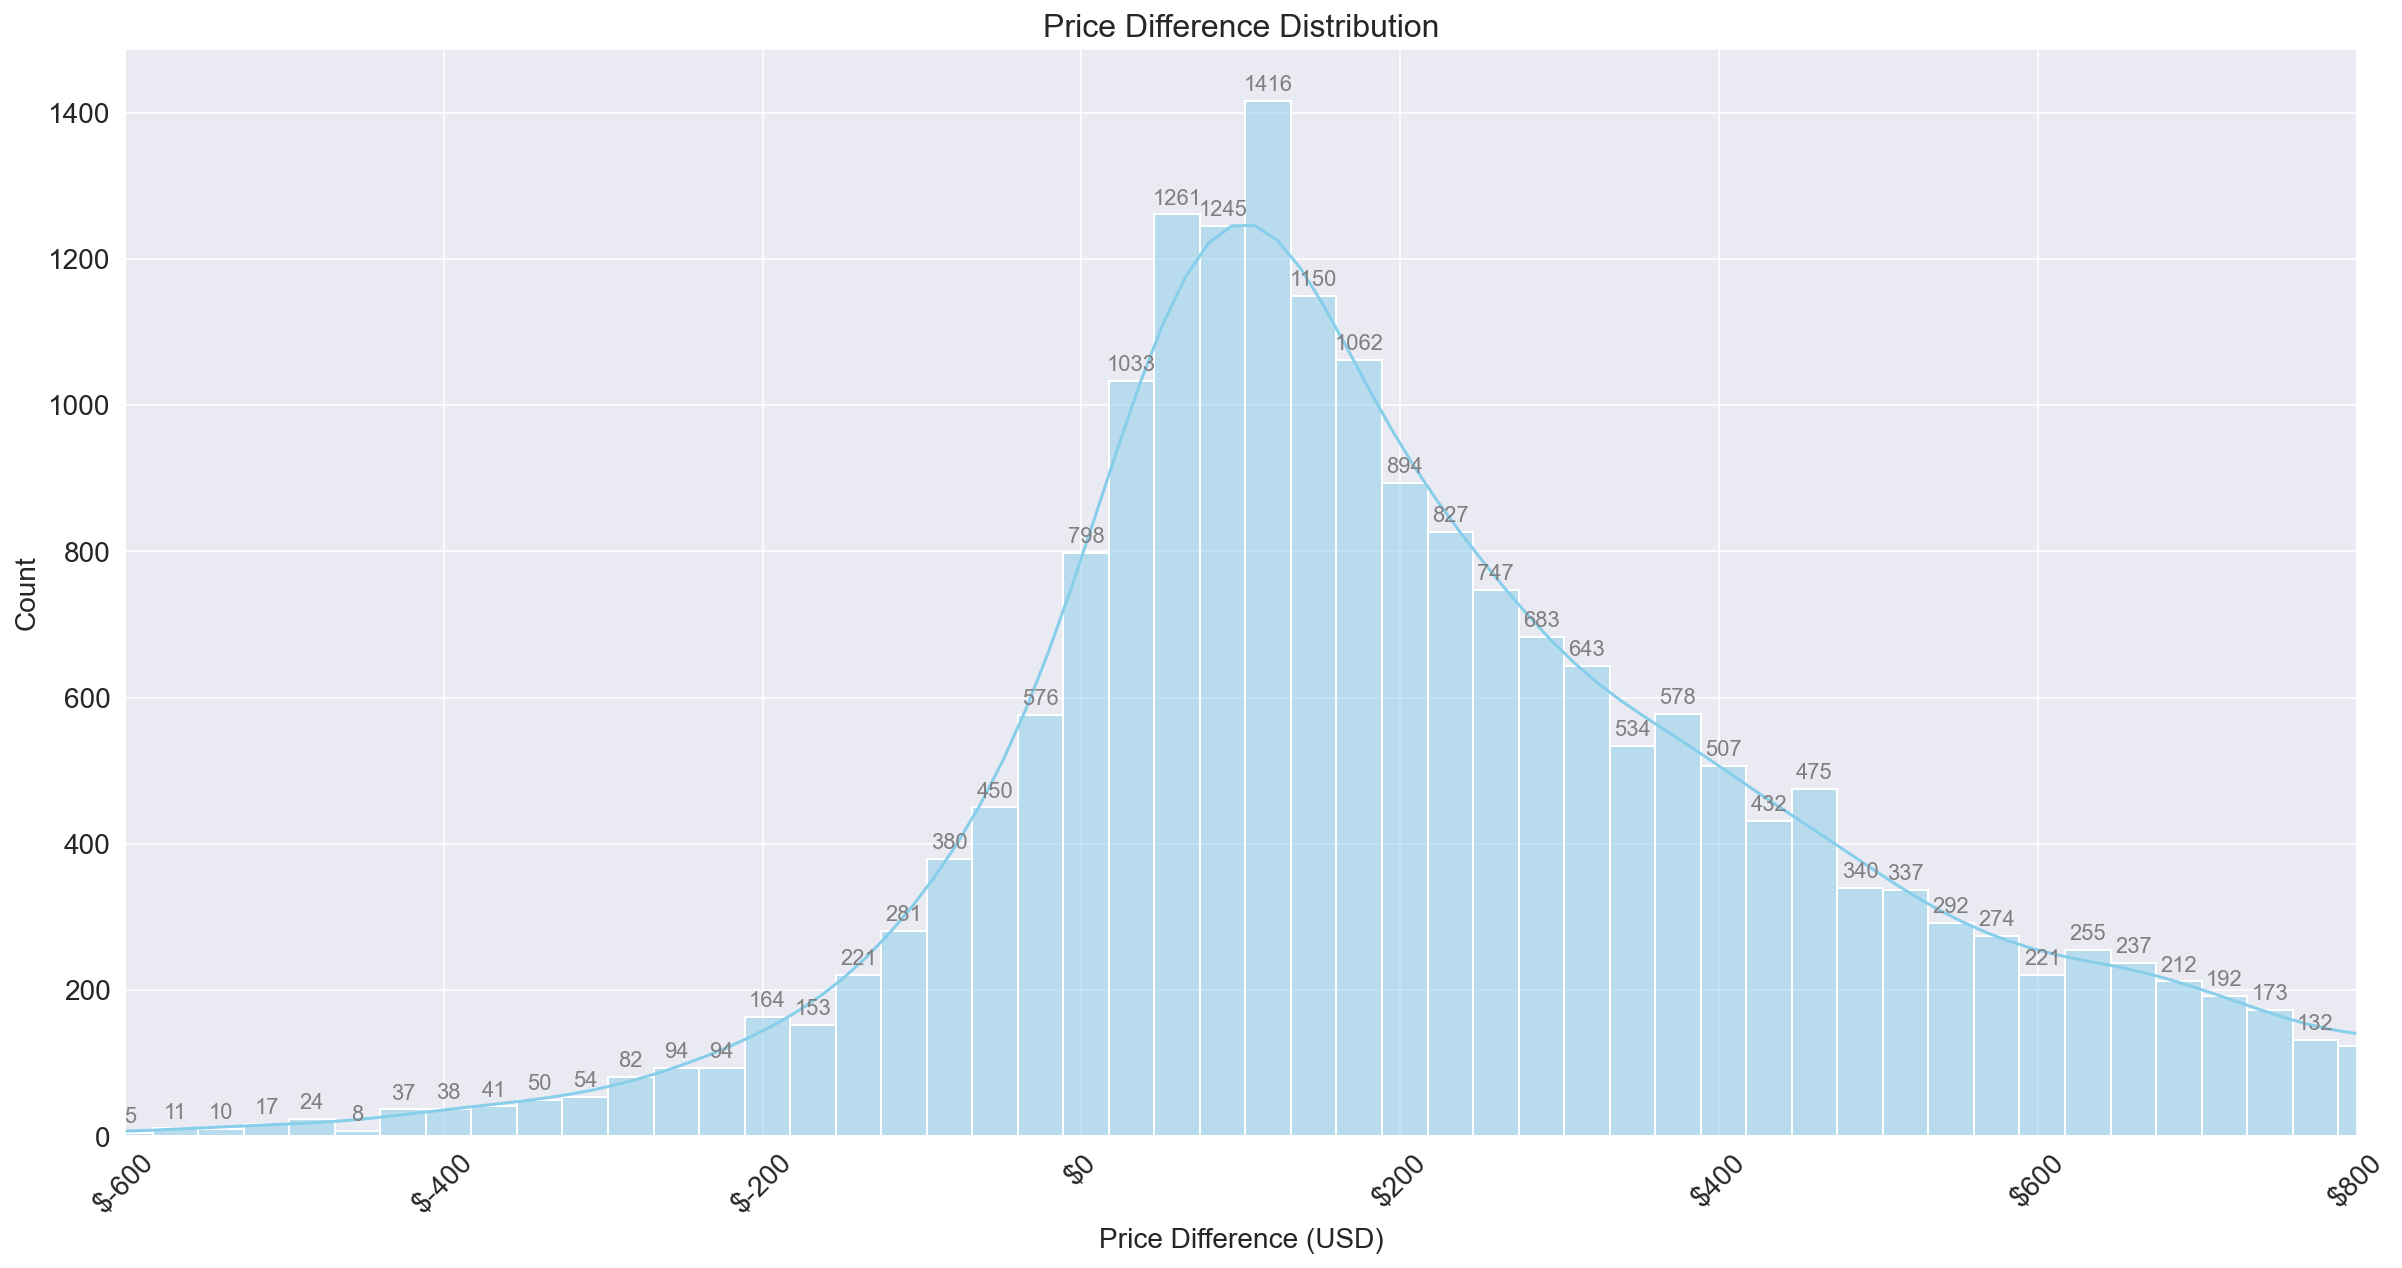

In [23]:
plt.figure(figsize=(20, 10))
sns.histplot(merged_df["PriceDiff"], bins=100, kde=True, alpha=0.5, color='skyblue')
plt.xlabel('Price Difference (USD)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Price Difference Distribution', fontsize=16)

for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 8),
                textcoords='offset points')

# Set x-axis limits and tick labels
xtick_labels = ['${}'.format(x) for x in range(-600, 801, 200)]
plt.xticks(range(-600, 801, 200), xtick_labels, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-600, 800)

plt.show()

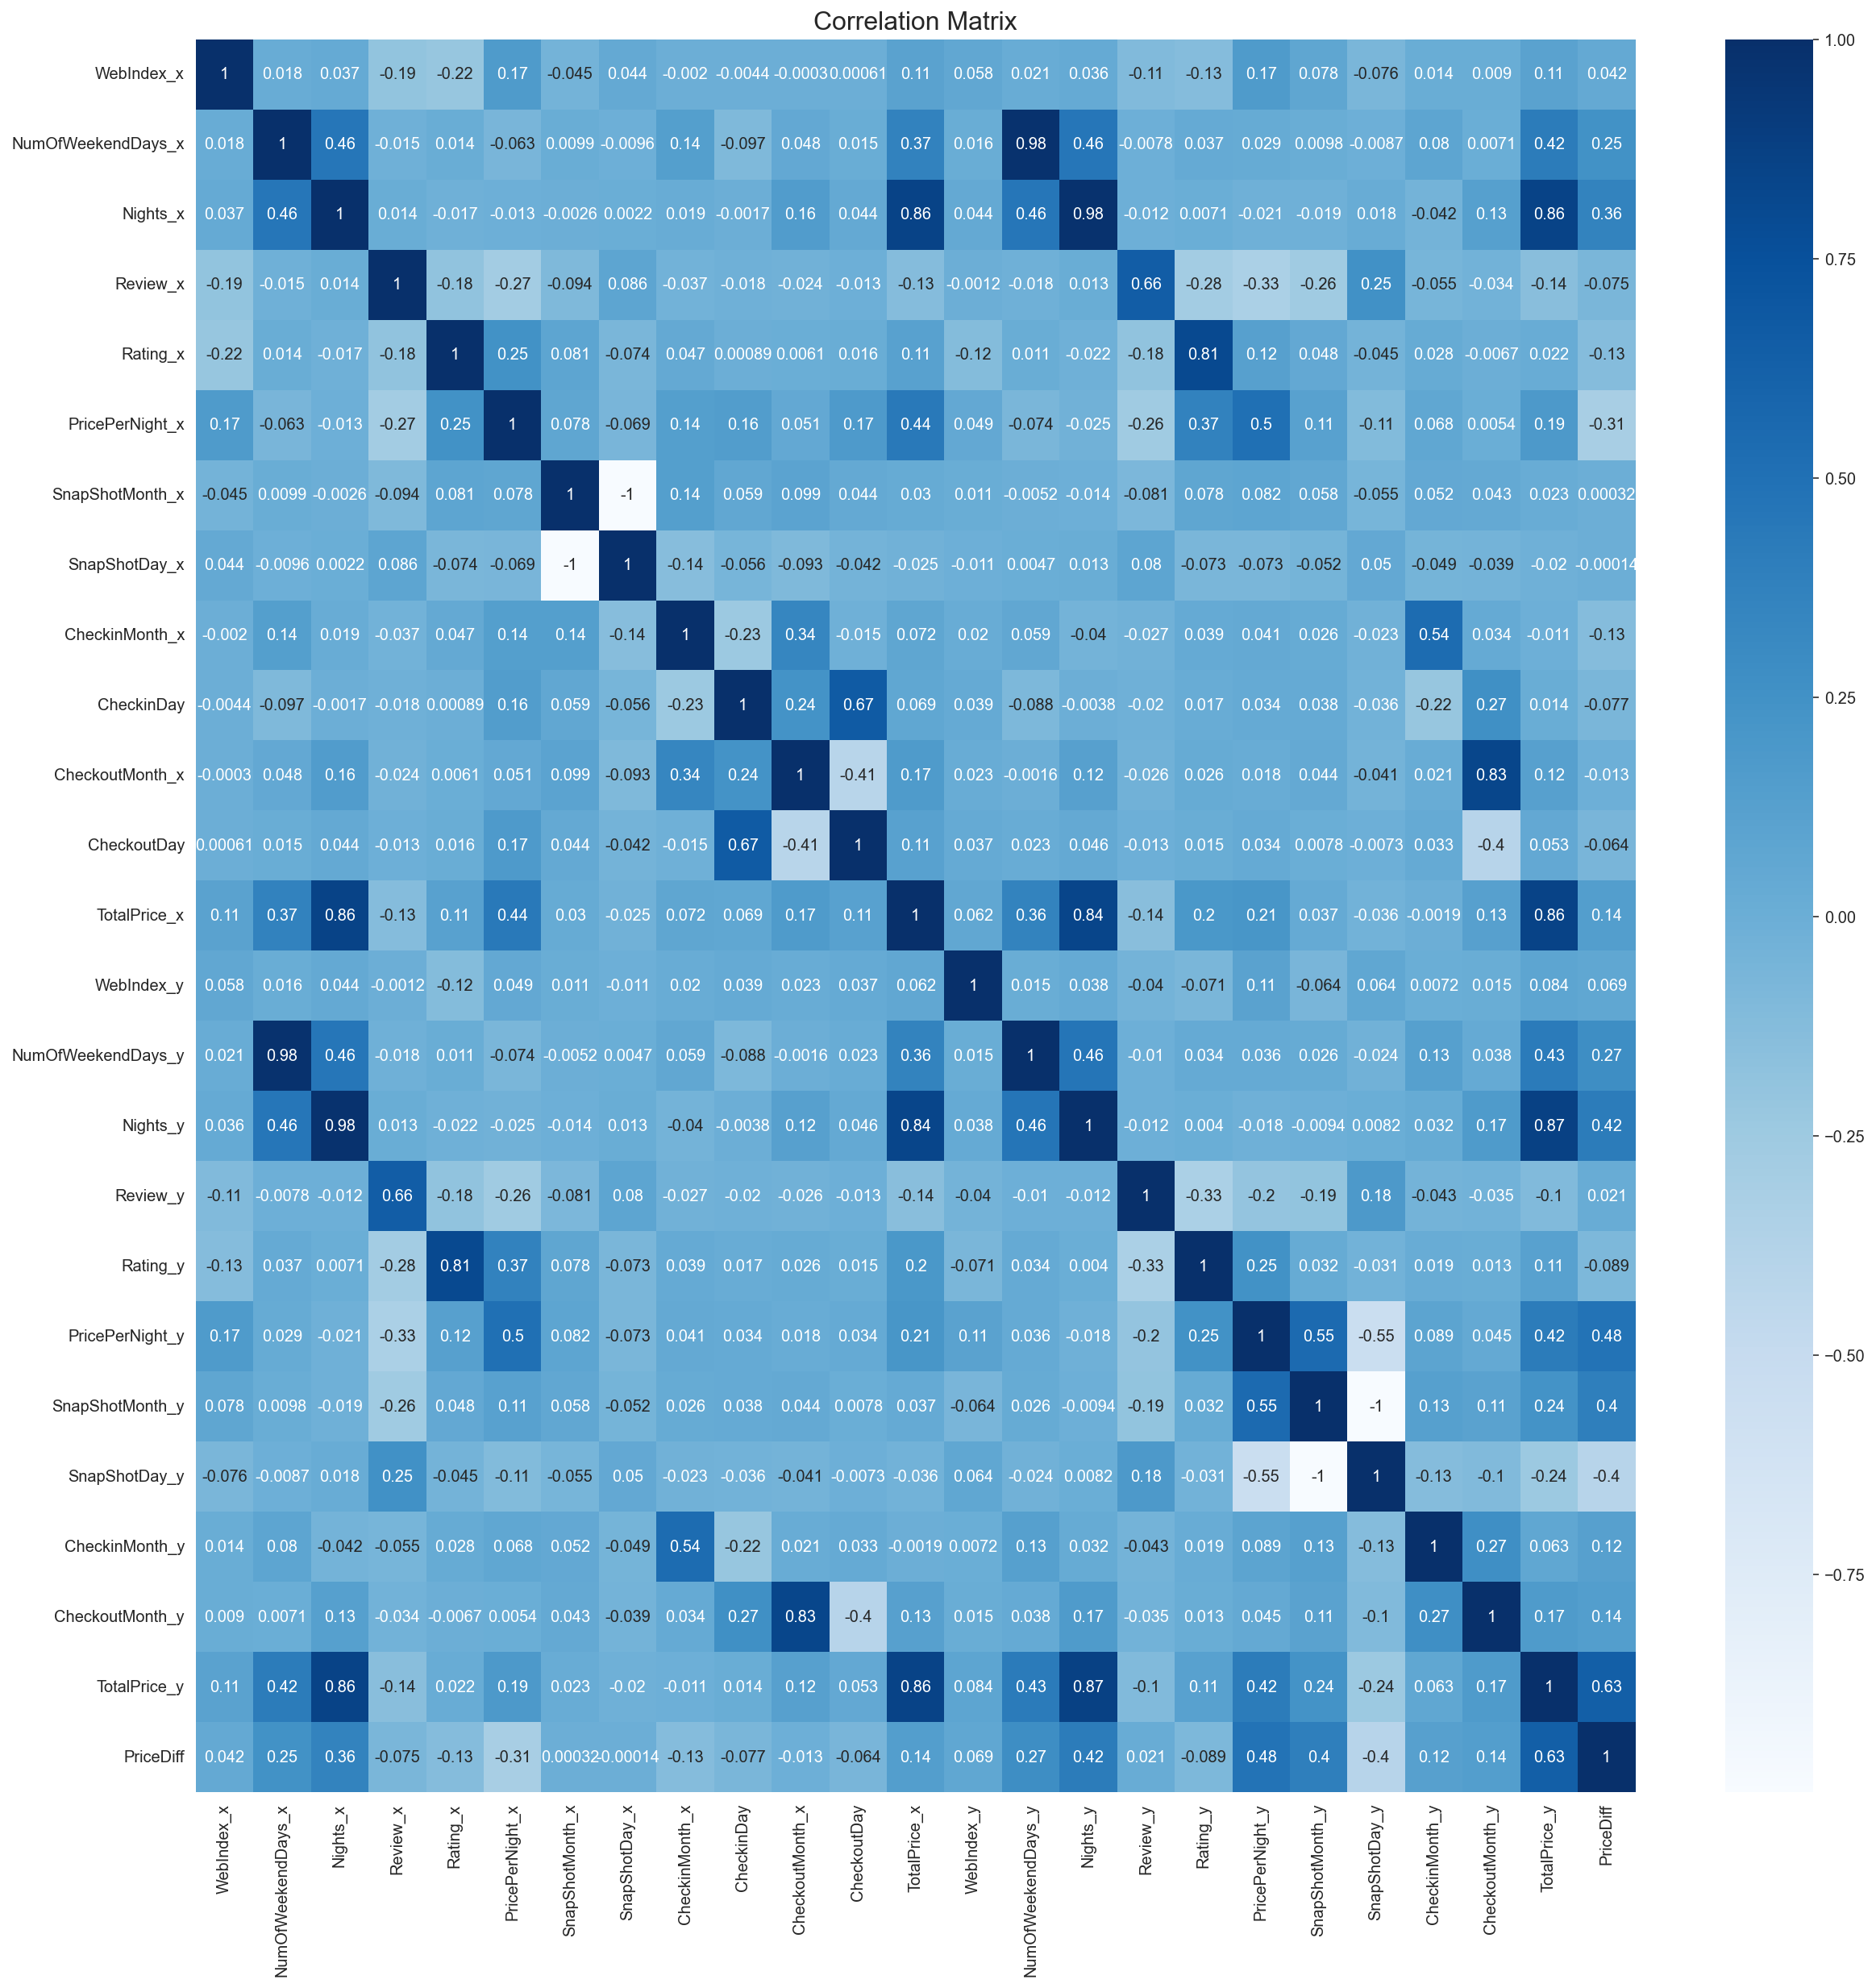

In [24]:
corr_matrix = merged_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True,cmap='Blues')
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# Models

In [25]:
def residual_scatter(y_test,y_pred_test,y_train,y_pred_train):
    residualsTest = y_test - y_pred_test
    residualsTrain = y_train - y_pred_train
    plt.figure(figsize=(23,10))
    plt.scatter(y_pred_train,residualsTrain,color='skyblue',marker='.',label='Training Data')
    plt.scatter(y_pred_test,residualsTest,color='navy',marker='.',label='Testing Data')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0,xmin=-300,xmax=2700,color='r')
    plt.show()
    
def residual_hist(y_test,y_pred_test,y_train,y_pred_train):
    residualsTest = y_test - y_pred_test
    residualsTrain = y_train - y_pred_train
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.distplot(residualsTest,hist=True,kde=True,ax=ax1)
    ax1.title.set_text('Test Residual Distribution')
    sns.distplot(residualsTrain,hist=True,kde=True,ax=ax2)
    ax2.title.set_text('Train Residual Distribution')
    plt.show()
    
def plot_tree(dt):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=500)

    tree.plot_tree(dt,
           feature_names = list(X.columns), 
           filled = True);


## LinearRegression

In [26]:
from sklearn.linear_model import LinearRegression

In [143]:
# Splitting the data

X = merged_df.drop(['PriceDiff','Name','CheckoutMonth_x','TotalPrice_x','SnapShotDay_y',
                   'NumOfWeekendDays_x','SnapShotDay_y','PricePerNight_x','TotalPrice_y'],axis = 1)
y = merged_df.PriceDiff

In [144]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [145]:
lr = LinearRegression()

In [146]:
lr.fit(X_train,y_train)

LinearRegression()

In [147]:
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

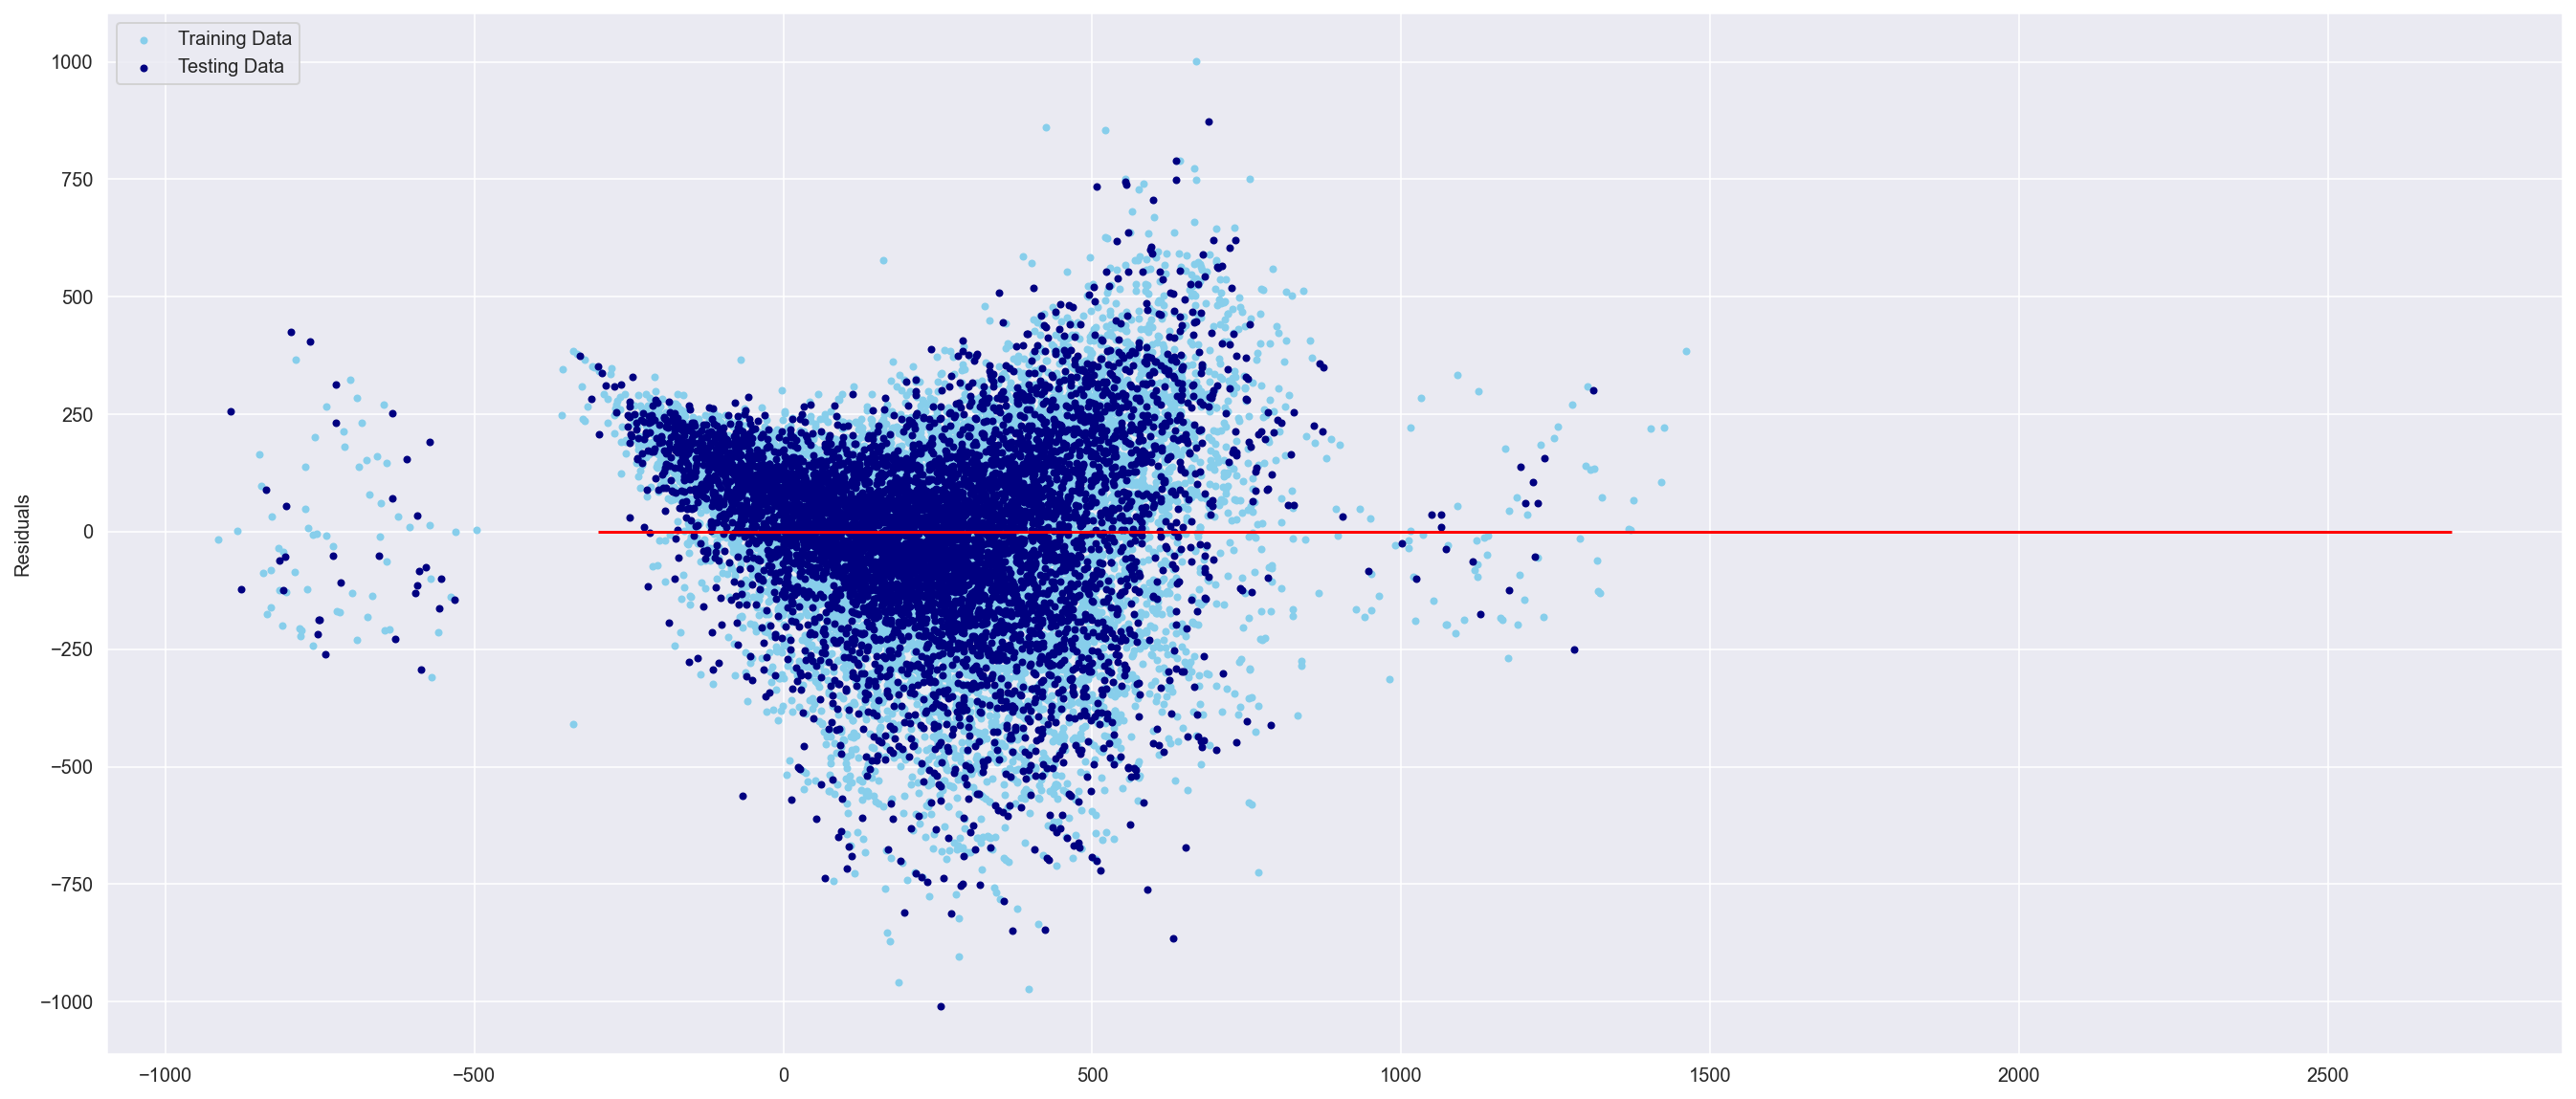

In [148]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

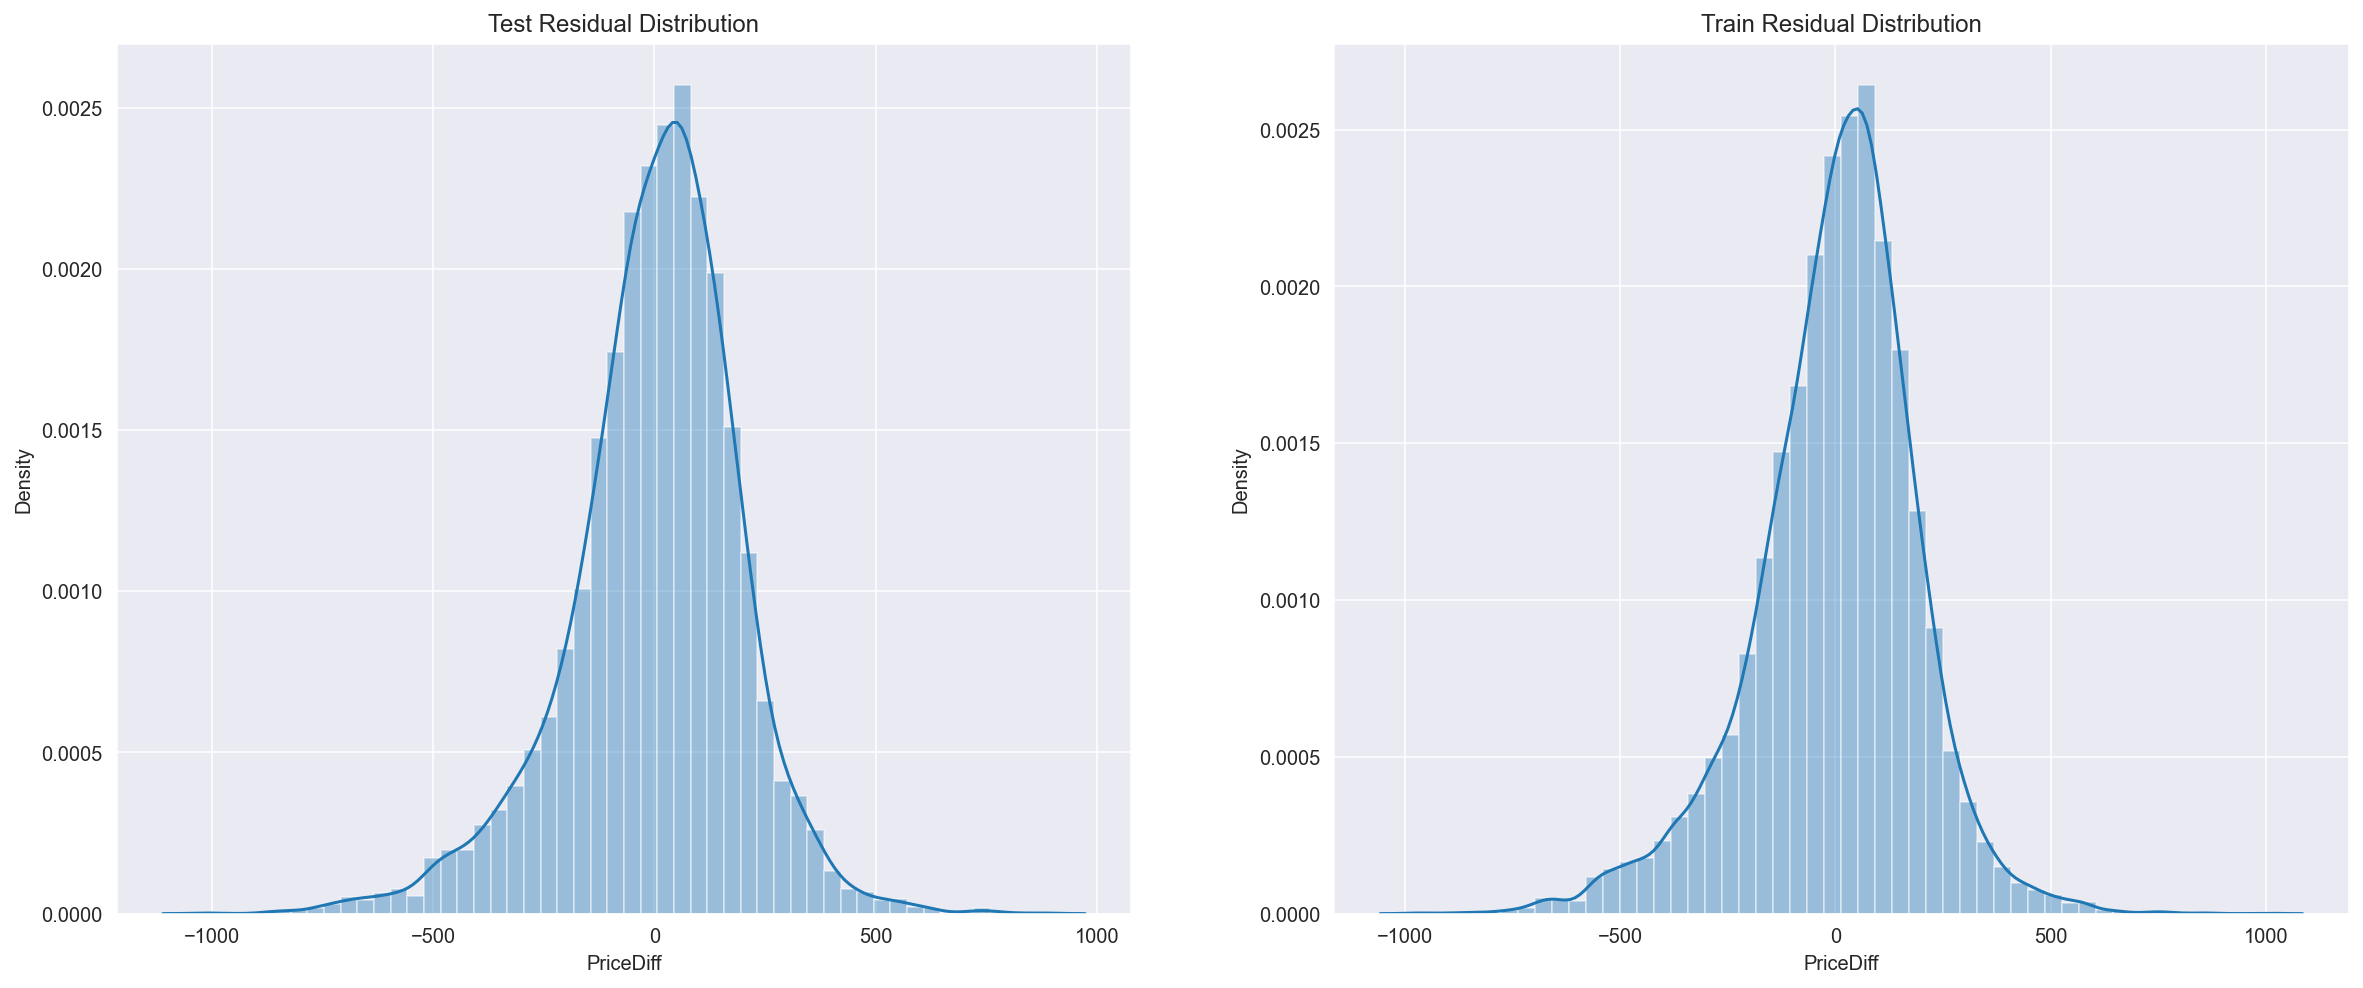

In [149]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [150]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
1985,108.0,131.342121,-23.342121
12579,420.0,264.436359,155.563641
10727,1083.0,644.404989,438.595011
3103,179.0,25.556536,153.443464
15680,-6.0,-121.415990,115.415990


In [151]:
lr1_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
lr1_MSE = mean_squared_error(y_test,y_pred_test)
lr1_MAE = mean_absolute_error(y_test,y_pred_test)
lr1_R2 = r2_score(y_test,y_pred_test)

print('RMSE',lr1_RMSE)
print('MSE',lr1_MSE)
print('MAE',lr1_MAE)
print('R2',lr1_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 193.33273881339076
MSE 37377.54789708677
MAE 144.96286909294741
R2 0.5601084988574099
R2 Train 0.5773281390099366


## DecisionTreeRegressor

In [117]:
from sklearn.tree import DecisionTreeRegressor

In [152]:
# Splitting the data

X = merged_df.drop(['PriceDiff','Name','CheckoutMonth_x','TotalPrice_x','SnapShotDay_y',
                   'NumOfWeekendDays_x','SnapShotDay_y','PricePerNight_x','TotalPrice_y'],axis = 1)
y = merged_df.PriceDiff

In [153]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [154]:
dt = DecisionTreeRegressor()

In [155]:
param_grid = {
    'max_depth': [7,8,9,10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [156]:
gs = GridSearchCV(dt, param_grid=param_grid, cv=4, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [158]:
print('dt best param : '  , gs.best_params_)
print('dt best score : '  , gs.best_score_)

dt best param :  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 4}
dt best score :  0.804440633842755


In [159]:
dt = DecisionTreeRegressor(**gs.best_params_)

In [160]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=4,
                      min_samples_split=4)

In [161]:
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

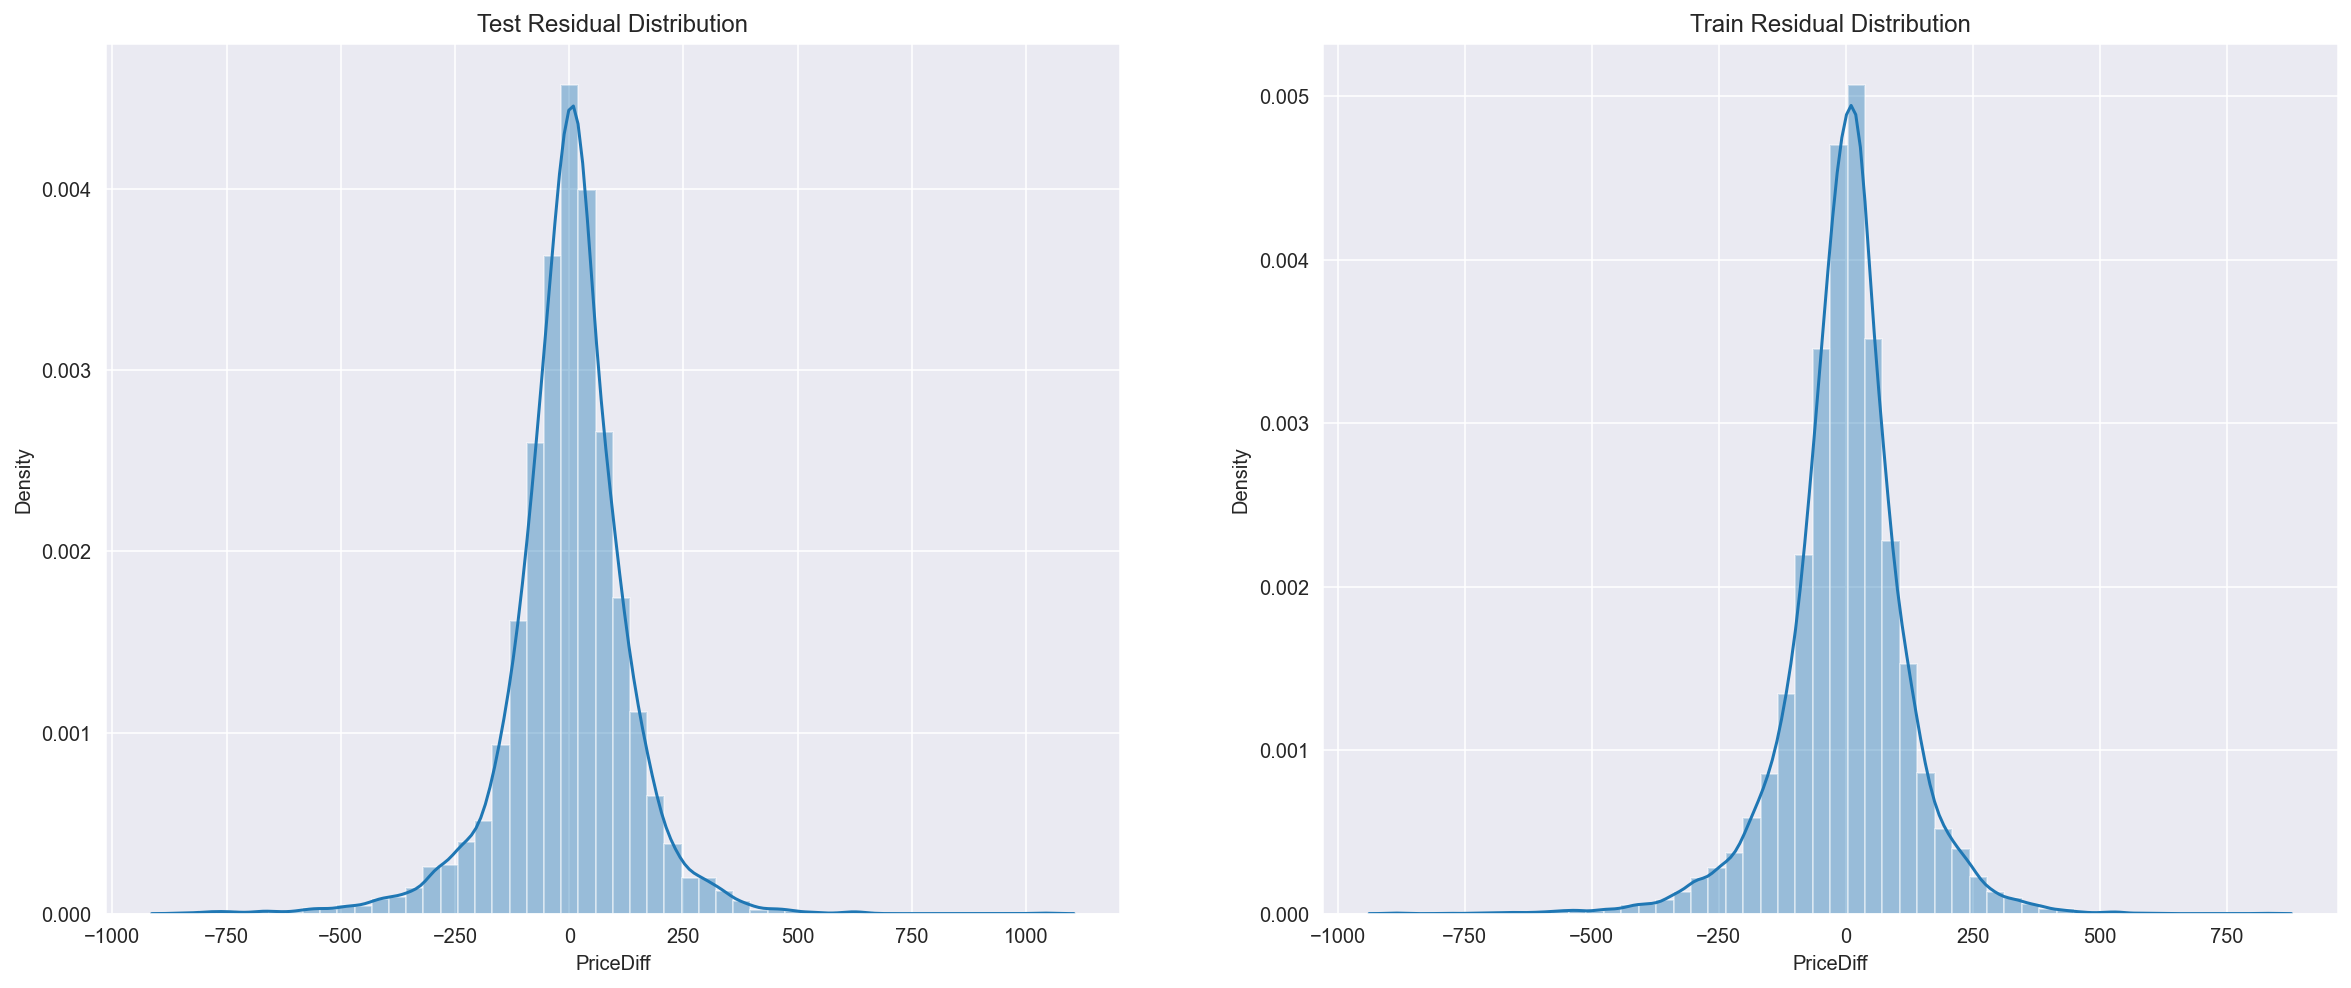

In [162]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [163]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
1985,108.0,200.447761,-92.447761
12579,420.0,327.377660,92.622340
10727,1083.0,998.333333,84.666667
3103,179.0,59.530405,119.469595
15680,-6.0,59.530405,-65.530405


In [164]:
dt2_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
dt2_MSE = mean_squared_error(y_test,y_pred_test)
dt2_MAE = mean_absolute_error(y_test,y_pred_test)
dt2_R2 = r2_score(y_test,y_pred_test)

print('RMSE',dt2_RMSE)
print('MSE',dt2_MSE)
print('MAE',dt2_MAE)
print('R2',dt2_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 129.6852344183731
MSE 16818.26002614839
MAE 90.02241608374787
R2 0.802068084565669
R2 Train 0.8444169639770704


## Gaussian Process Regression

In [165]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic, Sum, ExpSineSquared ,ConstantKernel

In [181]:
merged_df2 = merged_df.drop(['Name','CheckoutMonth_x','TotalPrice_x','SnapShotDay_y',
                   'NumOfWeekendDays_x','SnapShotDay_y','PricePerNight_x','TotalPrice_y'],axis = 1)

In [182]:
X = merged_df2.drop(['PriceDiff'],axis = 1)
y = merged_df.PriceDiff

In [183]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(merged_df2), columns=merged_df2.columns)

In [184]:
sample_df = df_normalized.sample(frac=0.4)

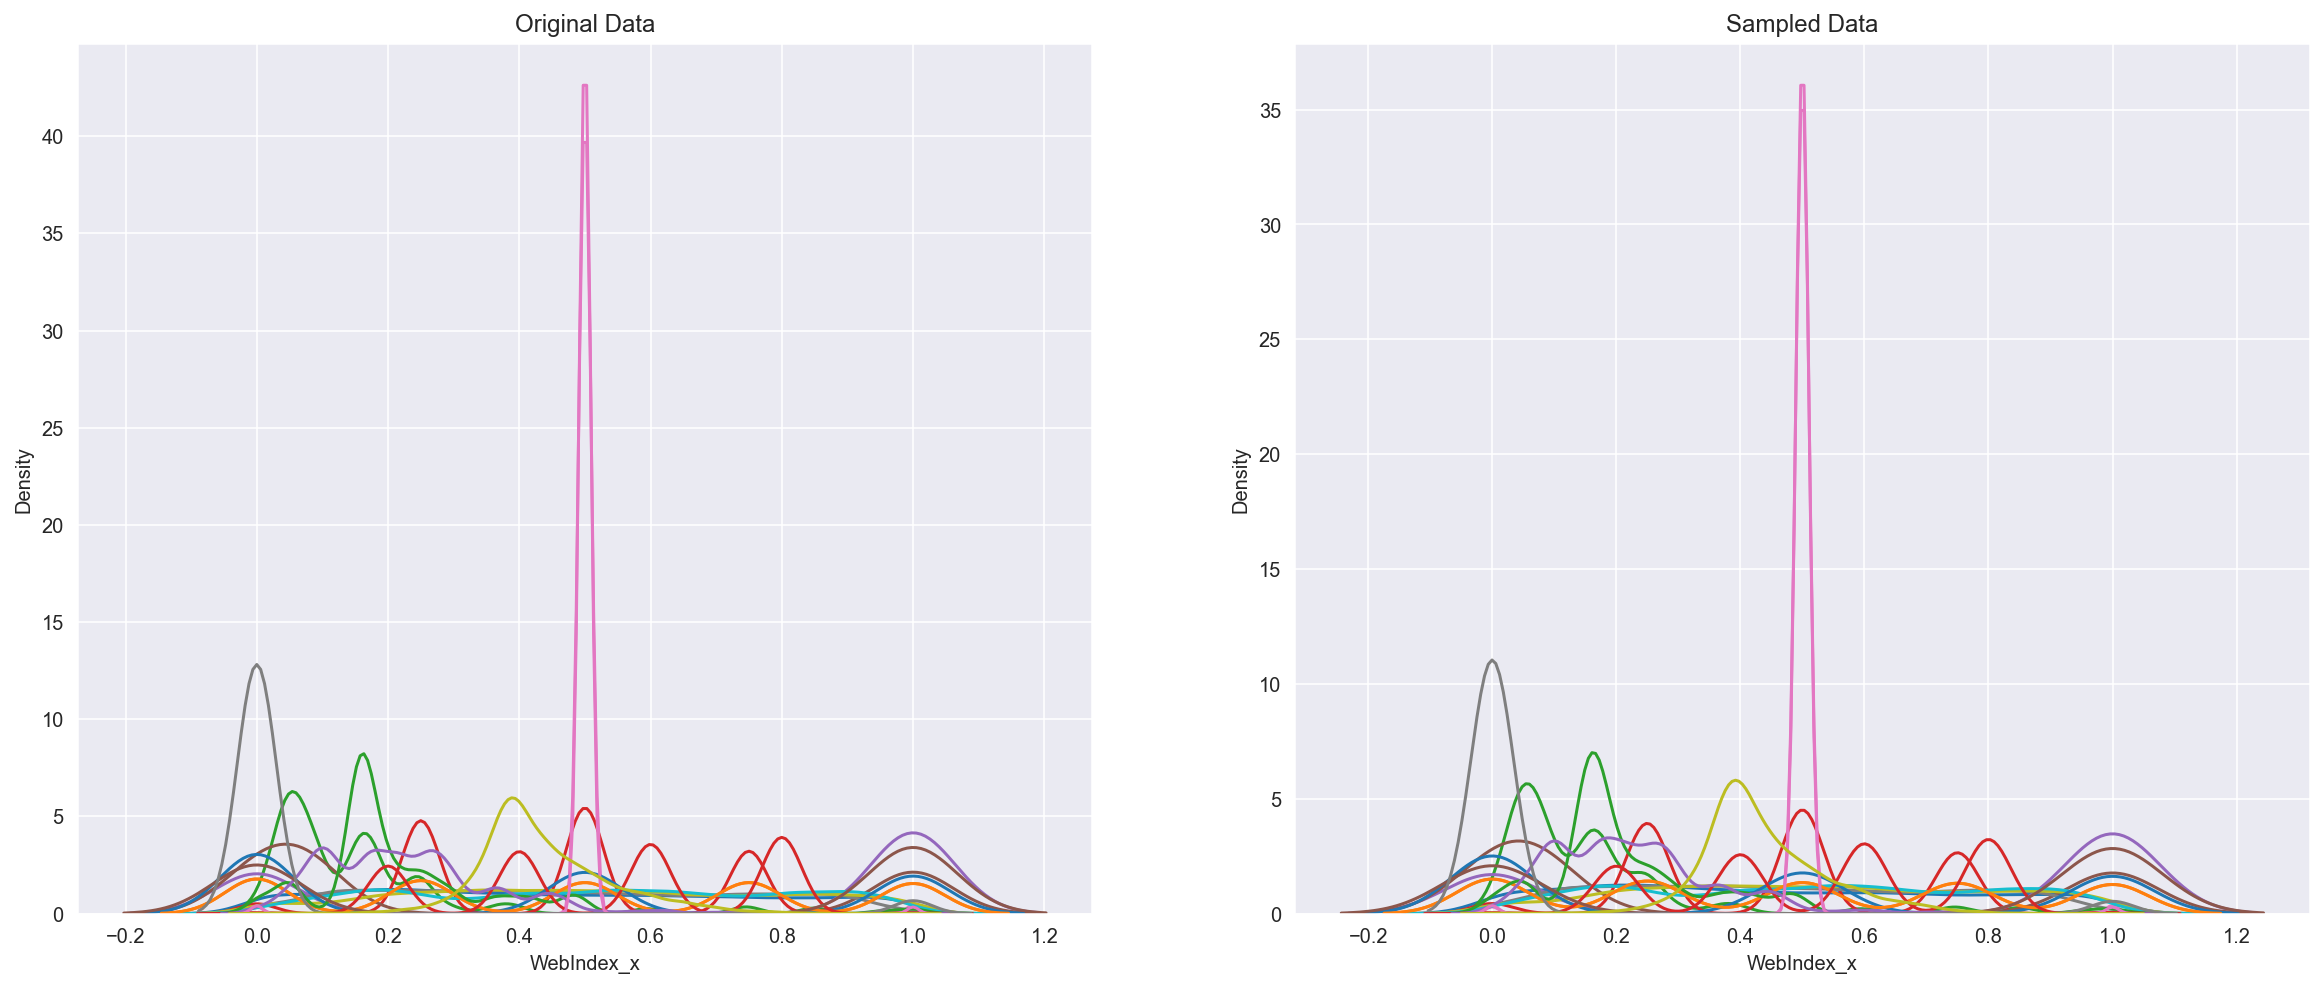

In [185]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
for i,col in enumerate(df_normalized[:-1]):
    sns.kdeplot(df_normalized[col],ax=ax1)
for i,col in enumerate(sample_df[:-1]):
    sns.kdeplot(sample_df[col],ax=ax2)
ax1.title.set_text('Original Data')
ax2.title.set_text('Sampled Data')

In [186]:
X = sample_df.drop('PriceDiff',axis = 1)
y  = sample_df.PriceDiff

In [187]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [191]:
kernels = [Product(DotProduct()+WhiteKernel(),RBF()),
         Product(DotProduct()+WhiteKernel(),Matern())]

In [192]:
param_grid = [{'kernel__k1__k2__noise_level':[0.2,0.5,0.7],
              'kernel__k2__length_scale':[0.8,1.0,1.2]},
             {'kernel__k1__k2__noise_level':[0.2,0.5,0.7],
             'kernel__k2__length_scale':[0.8,1.0,1.2],
             'kernel__k2__nu':[1.5,2.5]}]

In [ ]:
best_score  = -np.inf
for i,kernel in enumerate(kernels):
    gpr = GaussianProcessRegressor(kernel=kernel)
    gs = GridSearchCV(gpr, param_grid[i], cv=3,verbose=5)
    gs.fit(X_train,y_train)
    if gs.best_score_ > best_score:
        best_score = gs.best_score_
        best_kernel = gs.best_estimator_.kernel_

In [195]:
print('Best kernel is : ',best_kernel)
print('Score : ',best_score)

Best kernel is :  DotProduct(sigma_0=0.012) + WhiteKernel(noise_level=0.00153) * Matern(length_scale=11.8, nu=1.5)
Score :  0.7716656525620845


In [196]:
gpr = GaussianProcessRegressor(kernel=best_kernel)

In [197]:
with tqdm(total=100) as pbar:
    for i in range(100):
        gpr.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [12:02:11<00:00, 433.31s/it]


In [199]:
y_pred_train, y_pred_tr_std = gpr.predict(X_train, return_std=True)
y_pred_test, y_pred_te_std = gpr.predict(X_test, return_std=True)

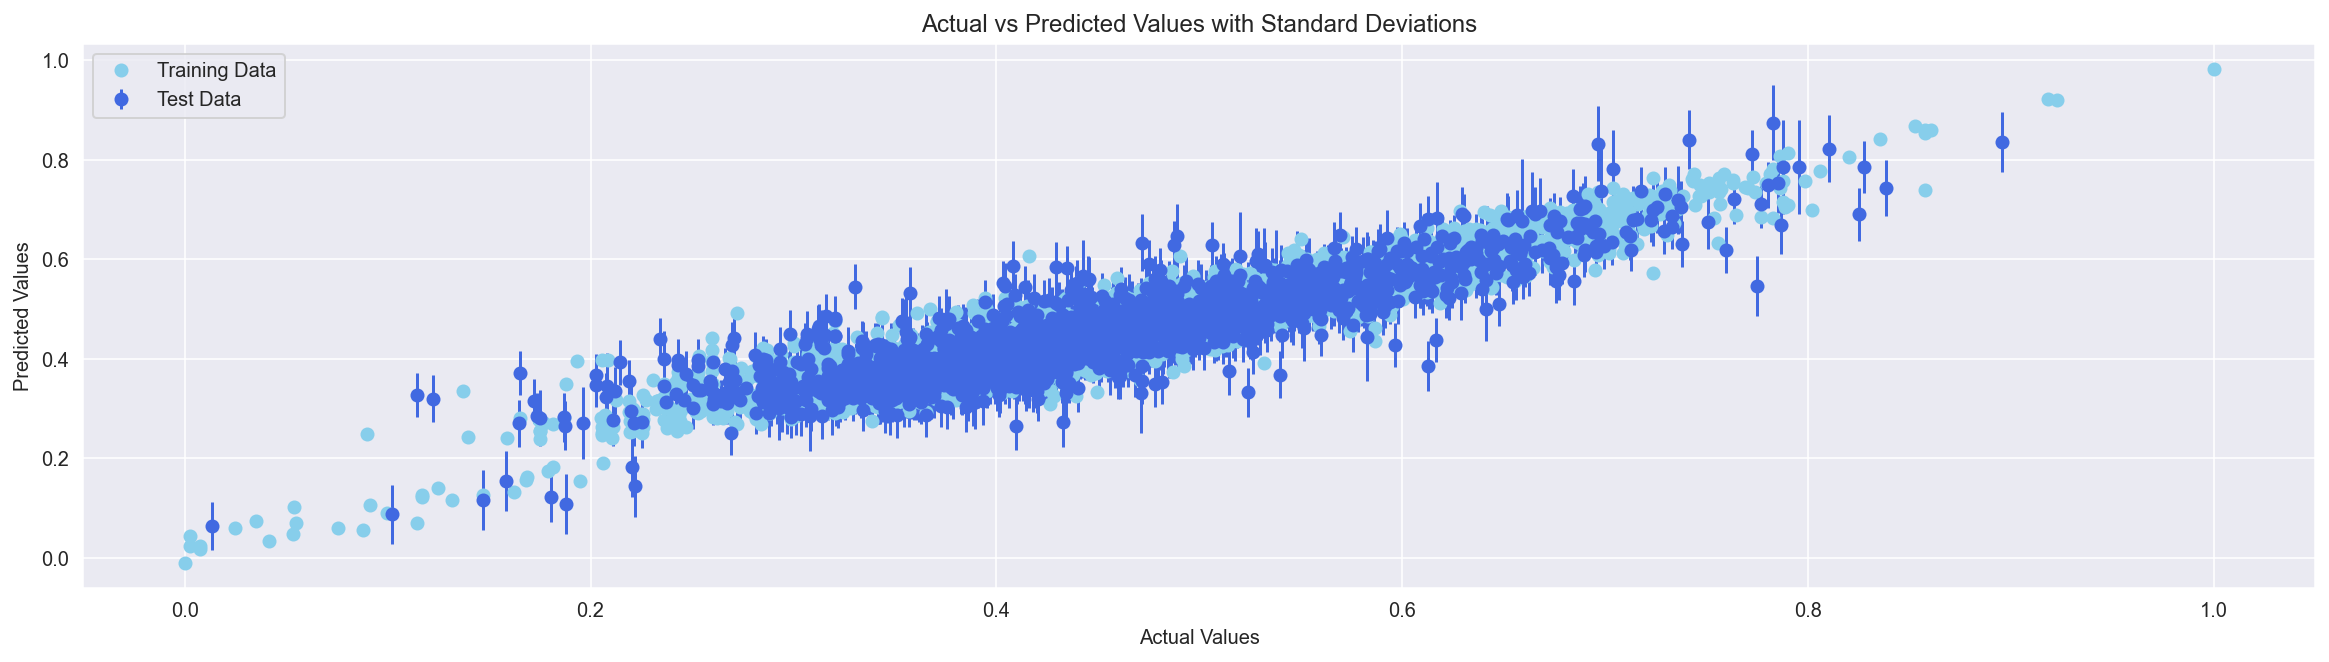

In [200]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.errorbar(y_test, y_pred_test, yerr=y_pred_te_std, fmt='o', color='royalblue', label='Test Data')
ax.plot(y_train, y_pred_train, 'o', color='skyblue', label='Training Data')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs Predicted Values with Standard Deviations')
ax.legend()

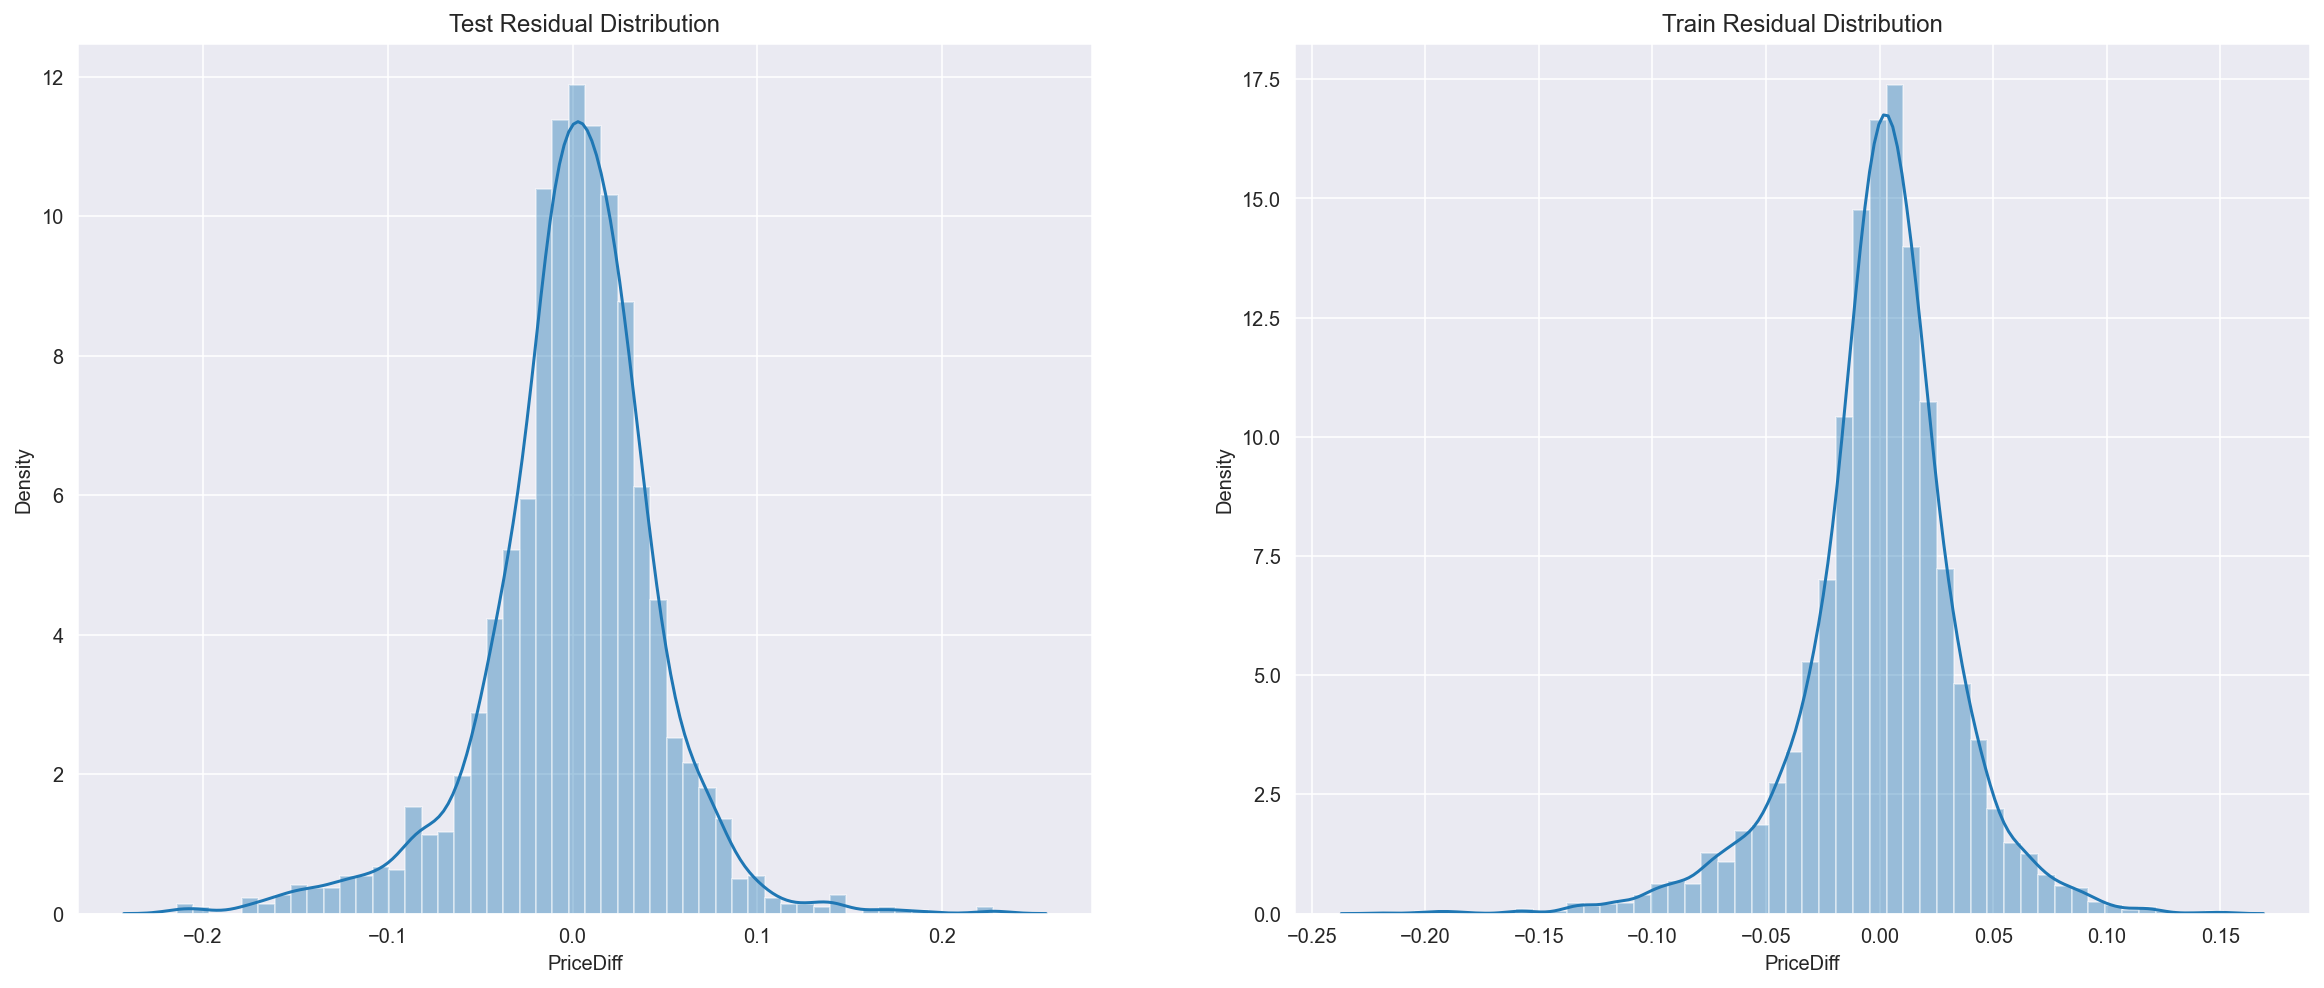

In [201]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [202]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
3149,0.440126,0.406027,0.034099
19992,0.340686,0.345633,-0.004947
20347,0.434524,0.375826,0.058698
16132,0.426120,0.386441,0.039680
7517,0.348389,0.343878,0.004511


In [203]:
gpr_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
gpr_MSE = mean_squared_error(y_test,y_pred_test)
gpr_MAE = mean_absolute_error(y_test,y_pred_test)
gpr_R2 = r2_score(y_test,y_pred_test)

print('RMSE',gpr_RMSE)
print('MSE',gpr_MSE)
print('MAE',gpr_MAE)
print('R2',gpr_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 0.045565731936198055
MSE 0.0020762359268814592
MAE 0.03255938847527811
R2 0.787476939369699
R2 Train 0.8924258882023274


### ElasticNet

In [204]:
from sklearn.linear_model import ElasticNet

In [205]:
X = merged_df.drop(['PriceDiff','Name','CheckoutMonth_x','TotalPrice_x','SnapShotDay_y',
                   'NumOfWeekendDays_x','SnapShotDay_y','PricePerNight_x','TotalPrice_y'],axis = 1)
y = merged_df.PriceDiff

In [206]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [207]:
en = ElasticNet()

In [208]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.25, 0.5, 0.75],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [1000, 5000, 10000],
}

In [209]:
gs = GridSearchCV(en, param_grid=param_grid, cv=3, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [211]:
print('en best param : '  , gs.best_params_)
print('en best score : '  , gs.best_score_)

en best param :  {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.75, 'max_iter': 1000, 'normalize': False}
en best score :  0.5745982235663941


In [212]:
en = ElasticNet(**gs.best_params_)

In [213]:
with tqdm(total=100) as pbar:
    for i in range(100):
        en.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s]


In [214]:
y_pred_test = en.predict(X_test)
y_pred_train = en.predict(X_train)

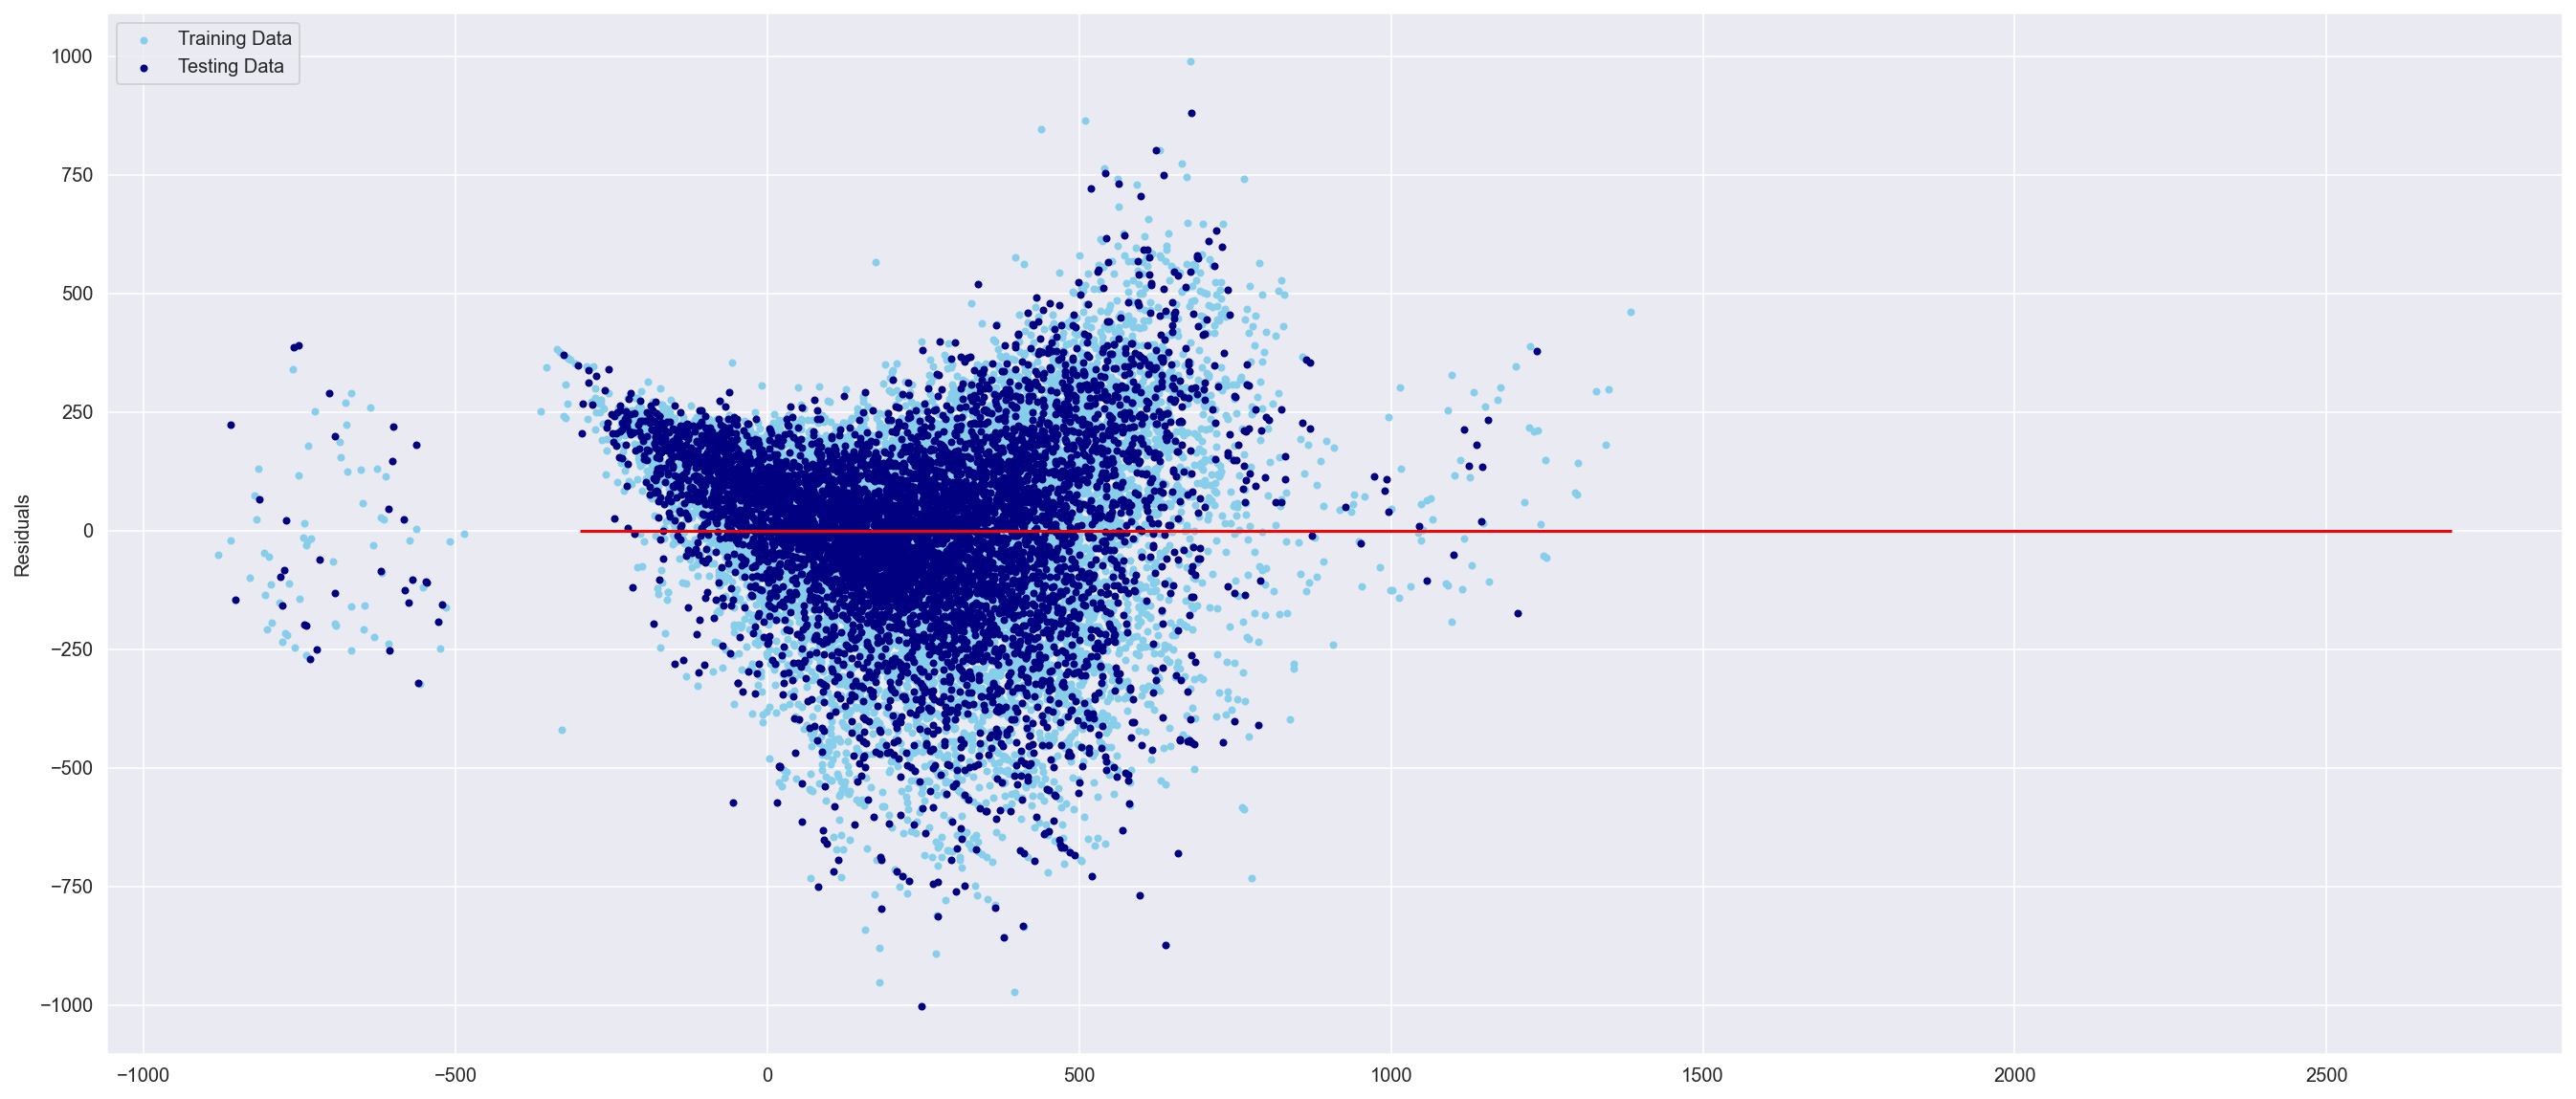

In [215]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

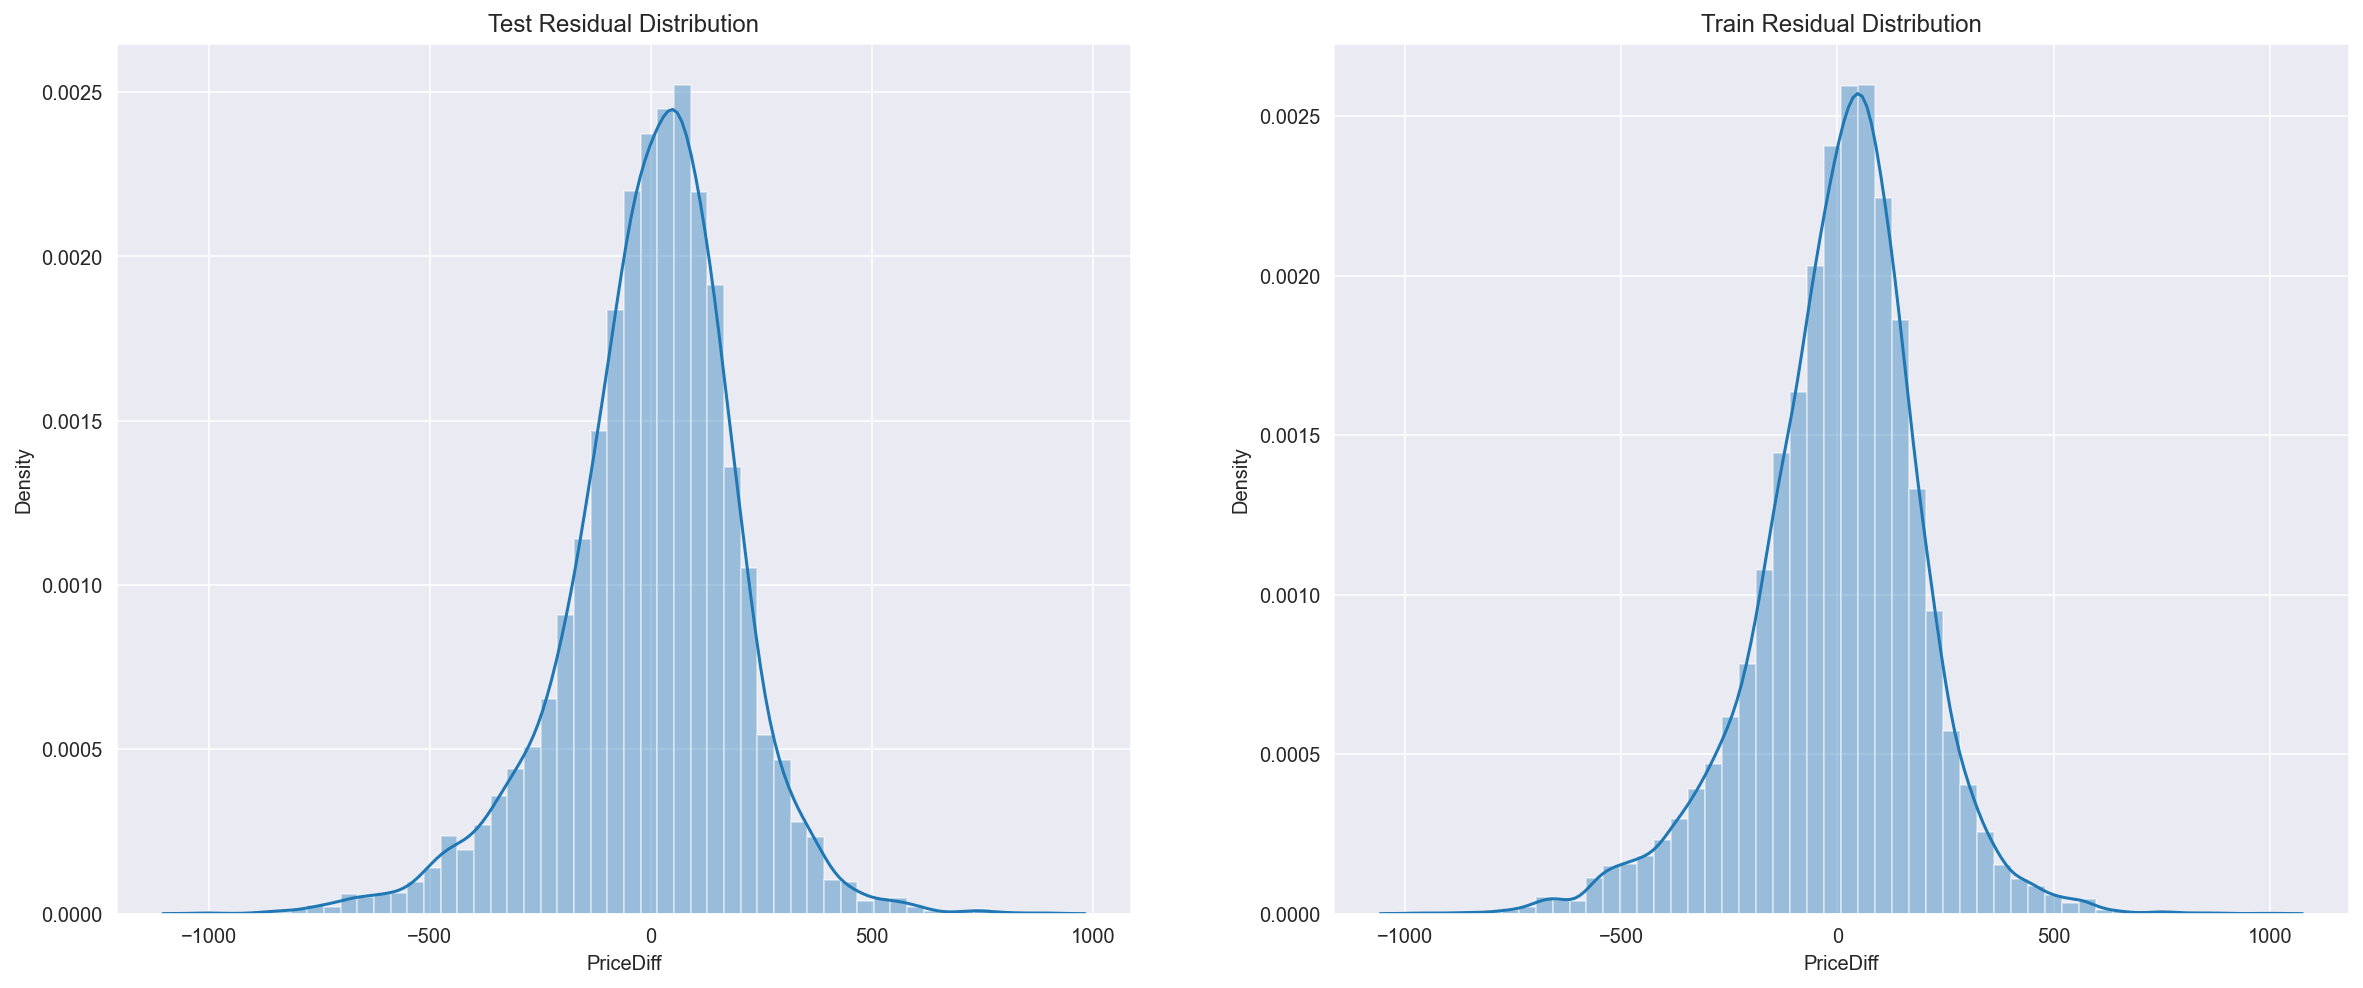

In [216]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [217]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
1985,108.0,121.837701,-13.837701
12579,420.0,250.130577,169.869423
10727,1083.0,629.446273,453.553727
3103,179.0,39.967331,139.032669
15680,-6.0,-108.857586,102.857586


In [218]:
es_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
es_MSE = mean_squared_error(y_test,y_pred_test)
es_MAE = mean_absolute_error(y_test,y_pred_test)
es_R2 = r2_score(y_test,y_pred_test)

print('RMSE',es_RMSE)
print('MSE',es_MSE)
print('MAE',es_MAE)
print('R2',es_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 193.510208751623
MSE 37446.200891096705
MAE 145.2013584399934
R2 0.5593005306975907
R2 Train 0.5756792305156316


### RandomForestRegressor

In [219]:
from sklearn.ensemble import RandomForestRegressor

In [220]:
X = merged_df.drop(['PriceDiff','Name','CheckoutMonth_x','TotalPrice_x','SnapShotDay_y',
                   'NumOfWeekendDays_x','SnapShotDay_y','PricePerNight_x','TotalPrice_y'],axis = 1)
y = merged_df.PriceDiff

In [221]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [222]:
rf = RandomForestRegressor()

In [223]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [8,9,10],
    'min_samples_split': [2,3,4, 5],
    'min_samples_leaf': [2, 4,5],
    'max_features': ['sqrt', 'log2', None]  
}

In [224]:
gs = GridSearchCV(rf, param_grid=param_grid, cv=3, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [226]:
print('rf best param : '  , gs.best_params_)
print('rf best score : '  , gs.best_score_)

rf best param :  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
rf best score :  0.8608181170953803


In [227]:
rf = RandomForestRegressor(**gs.best_params_)

In [228]:
with tqdm(total=100) as pbar:
    for i in range(100):
        rf.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [31:20<00:00, 18.81s/it]


In [229]:
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [230]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
1985,108.0,153.870681,-45.870681
12579,420.0,323.994130,96.005870
10727,1083.0,1067.885567,15.114433
3103,179.0,87.283327,91.716673
15680,-6.0,45.090041,-51.090041


In [231]:
rf_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
rf_MSE = mean_squared_error(y_test,y_pred_test)
rf_MAE = mean_absolute_error(y_test,y_pred_test)
rf_R2 = r2_score(y_test,y_pred_test)

print('RMSE',rf_RMSE)
print('MSE',rf_MSE)
print('MAE',rf_MAE)
print('R2',rf_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 107.60718073426676
MSE 11579.305345577153
MAE 74.8896786782288
R2 0.8637246610002645
R2 Train 0.9001178661041449


### XGBoostRegressor

In [232]:
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space.space import Real ,Categorical,Integer
from xgboost import plot_importance

In [233]:
X = merged_df.drop(['PriceDiff','Name','Nights_y','CheckoutMonth_x','TotalPrice_x','SnapShotDay_y','Rating_x',
                   'NumOfWeekendDays_x','SnapShotDay_y','PricePerNight_y','PricePerNight_x','TotalPrice_y'],axis = 1)
y = merged_df.PriceDiff

In [234]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [235]:
estimators = [
    ('encoder',TargetEncoder()),
    ('clf',XGBRegressor())
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_pa

In [236]:
search_space = {
    'clf__max_depth':Integer(2,8),
    'clf__learning_rate':Real(0.001,1.0,prior='log-uniform'),
    'clf__subsample':Real(0.5,1.0),
    'clf__colsample_bytree':Real(0.5,1.0),
    'clf__colsample_bylever':Real(0.5,1.0),
    'clf__colsample_bynode':Real(0.5,1.0),
    'clf__reg_alpha':Real(0.0,10.0),
    'clf__reg_lamda':Real(0.0,10.0),
    'clf__gamma':Real(0.0,10.0)
    
}

opt = BayesSearchCV(pipe,search_space,cv=3,n_iter=10,scoring='r2',random_state=8)

In [ ]:
opt.fit(X_train,y_train)

In [238]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None,
                              colsample_bylever=0.6854728136721551,
                              colsample_bynode=0.9716292421559054,
                              colsample_bytree=0.9999681720272138,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=9.2693427...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.4165635668761467, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth

In [239]:
y_pred_test = opt.predict(X_test)
y_pred_train = opt.predict(X_train)

In [240]:
opt.best_estimator_.steps

[('encoder', TargetEncoder(cols=[])),
 ('clf',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bylever=0.6854728136721551,
               colsample_bynode=0.9716292421559054,
               colsample_bytree=0.9999681720272138, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=9.269342703724346, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.4165635668761467, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, ...))]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

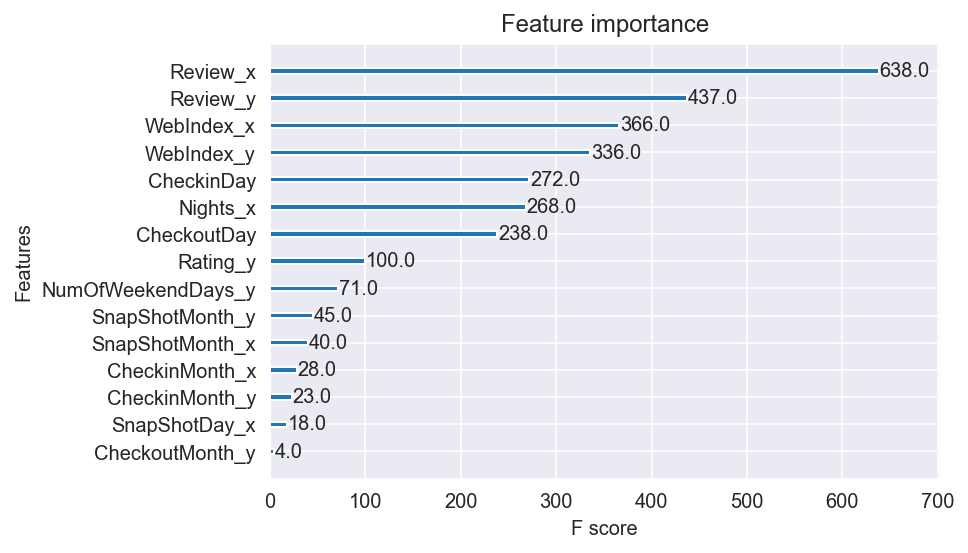

In [241]:
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

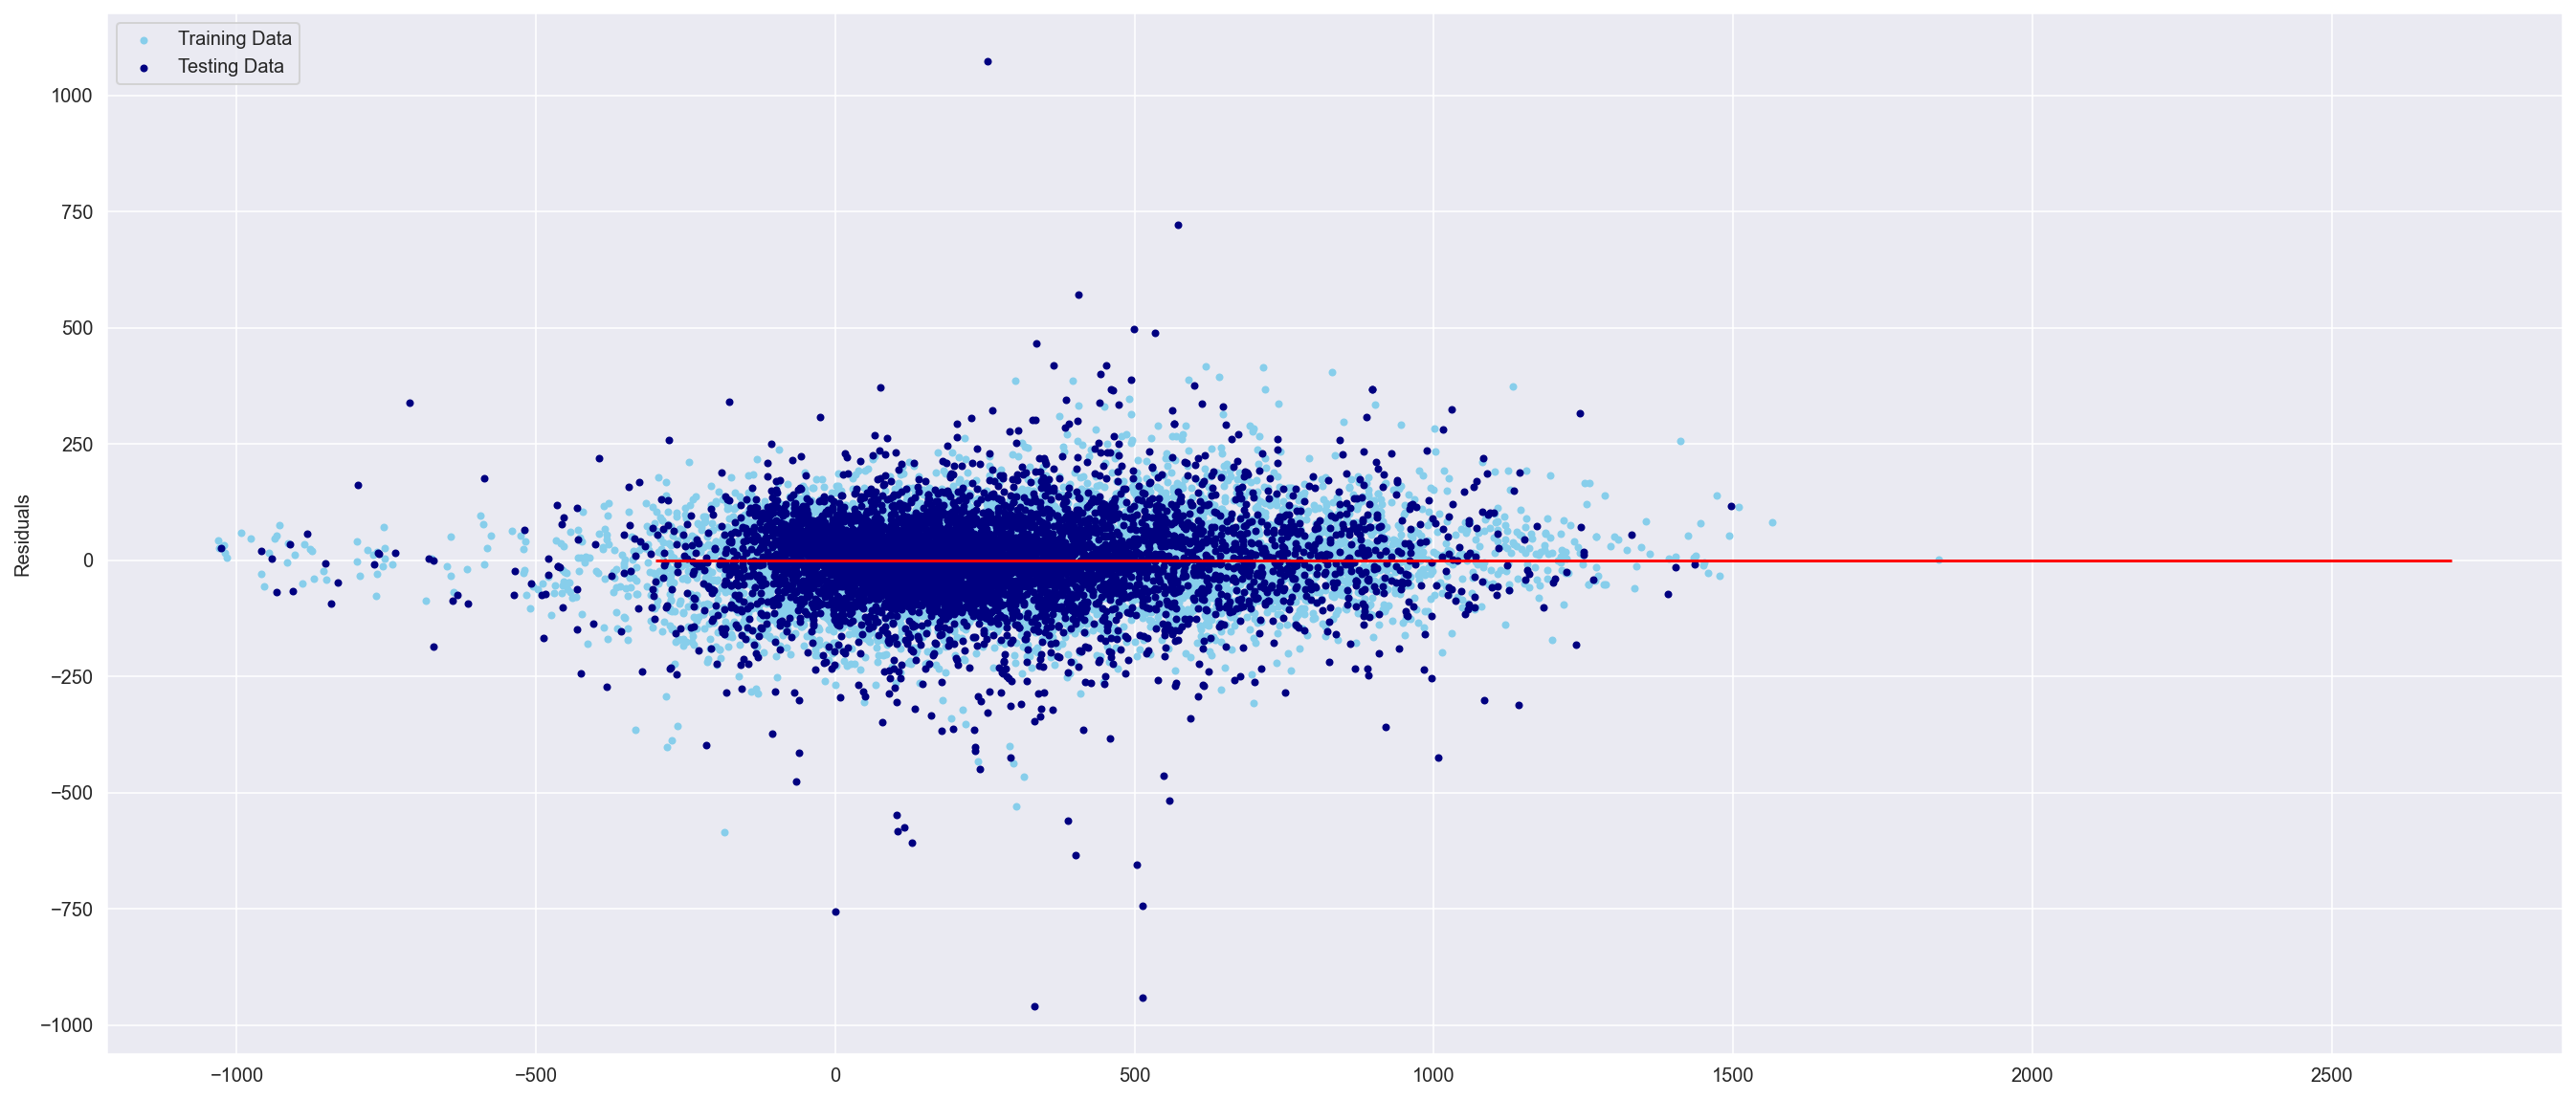

In [242]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

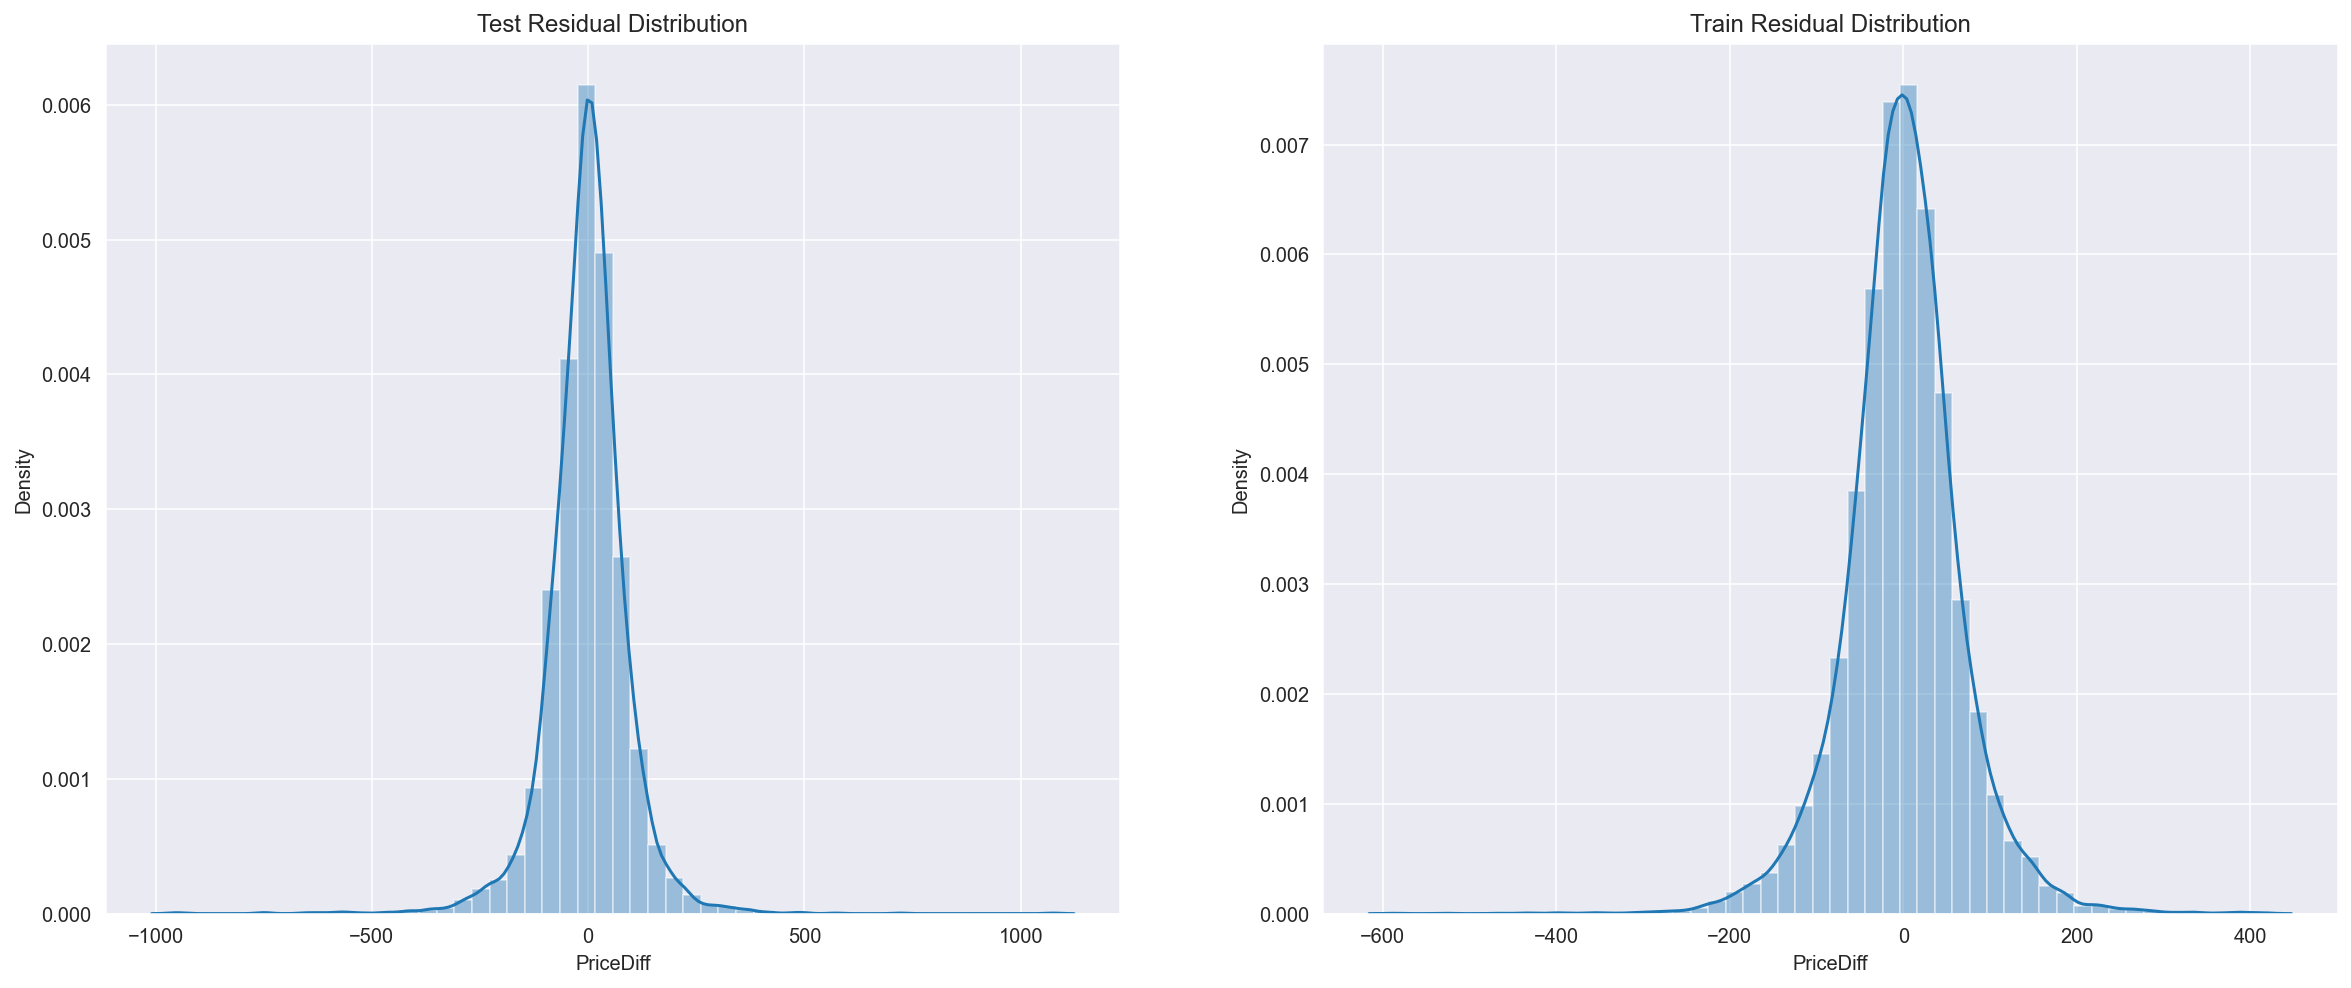

In [243]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [244]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
1985,108.0,145.326340,-37.326340
12579,420.0,381.545197,38.454803
10727,1083.0,1015.907471,67.092529
3103,179.0,139.893539,39.106461
15680,-6.0,34.443455,-40.443455


In [245]:
opt_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
opt_MSE = mean_squared_error(y_test,y_pred_test)
opt_MAE = mean_absolute_error(y_test,y_pred_test)
opt_R2 = r2_score(y_test,y_pred_test)

print('RMSE',opt_RMSE)
print('MSE',opt_MSE)
print('MAE',opt_MAE)
print('R2',opt_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 93.70831702200597
MSE 8781.248679096774
MAE 63.61816578086899
R2 0.8966546260875681
R2 Train 0.9473871365063894


# Models summary

In [246]:
models = pd.DataFrame({'Model' : ['LinearRegression' , 'DecisionTree' ,
                                   'GPR','ElasticNet',
                                 'RandomForestRegressor','XGBoost'],
                      'RMSE' : [lr1_RMSE , dt2_RMSE ,gpr_RMSE,
                               es_RMSE,rf_RMSE,opt_RMSE],
                      'MSE' : [lr1_MSE , dt2_MSE ,gpr_MSE,
                               es_MSE,rf_MSE,opt_MSE],
                      'MAE' : [lr1_MAE  , dt2_MAE,gpr_MAE,
                               es_MAE,rf_MAE,opt_MAE],
                      'R2' : [lr1_R2, dt2_R2 ,gpr_R2,
                               es_R2,rf_R2,opt_R2]})

In [247]:
models.sort_values(by = 'R2', ascending = False)

,Model,RMSE,MSE,MAE,R2
5,XGBoost,93.708317,8781.248679,63.618166,0.896655
4,RandomForestRegressor,107.607181,11579.305346,74.889679,0.863725
1,DecisionTree,129.685234,16818.260026,90.022416,0.802068
2,GPR,0.045566,0.002076,0.032559,0.787477
0,LinearRegression,193.332739,37377.547897,144.962869,0.560108
3,ElasticNet,193.510209,37446.200891,145.201358,0.559301
